# PROJECT EDA

**Process to explore the data and identify patterns in the data**

In [300]:
# Import necessary libraries
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score


pd.set_option("display.max_columns", 100)


In [301]:
# Load the main dataset 
df = pd.read_csv('cleaned_dataset.csv')

# Display the first few rows of the dataset 
df.head()

,LoanId,AmountDisbursed,Interest,LoanBalance,BorrowDate,Product,Branch,ClearDate,CustomerId,Gender,LoanLimit,CreditScore,loan_repayment_txn_count,loan_repayment_total_paid,loan_repayment_first_payment,loan_repayment_last_payment,loan_overpayment,MissedInstalments,Industry,BusinessType,YearEstablished
0,951920,6000,1750,7750.0,2025-11-29,5 weeks credit ease,engineer,2026-03-01,1819,female,8000.0,3500,1,500,2025-11-29,2025-11-29,0,5.0,food & hospitality,green grocery (fruit/vegetables),2017
1,951902,4000,1250,5250.0,2025-11-28,5 weeks credit ease,molo,2026-02-01,1818,female,9600.0,2500,1,1550,2025-11-28,2025-11-28,0,4.0,food & hospitality,retail shop,2019
2,949962,4000,1250,5250.0,2025-11-26,5 weeks credit ease,engineer,2025-12-31,1815,female,8000.0,3500,1,1350,2025-11-26,2025-11-26,0,4.0,food & hospitality,green grocery (fruit/vegetables),2014
3,949189,4000,1250,5250.0,2025-11-25,5 weeks credit ease,molo,2025-12-30,1814,female,10000.0,1500,1,1000,2025-11-25,2025-11-25,0,4.0,food & hospitality,green grocery (fruit/vegetables),2018
4,948984,4000,1250,5250.0,2025-11-24,5 weeks credit ease,molo,2025-12-29,1813,female,10000.0,1500,1,1550,2025-11-24,2025-11-24,0,4.0,business & information,bureau & publishing services,2018


In [302]:
# James: Convert date columns to datetime format for easier analysis

# BorrowDate:  MM/DD/YYYY (Keep dayfirst=False)
df["BorrowDate"] = pd.to_datetime(df["BorrowDate"], errors="coerce", dayfirst=False)

# problematic columns: Use format='mixed' to handle the mix of DD/MM/YYYY and YYYY-MM-DD
df["loan_repayment_first_payment"] = pd.to_datetime(df["loan_repayment_first_payment"], errors="coerce", dayfirst=True, format='mixed')
df["loan_repayment_last_payment"] = pd.to_datetime(df["loan_repayment_last_payment"], errors="coerce", dayfirst=True, format='mixed')

# ClearDate:  YYYY-MM-DD
df["ClearDate"] = pd.to_datetime(df["ClearDate"], errors="coerce", format="%Y-%m-%d")

# Check the result
df.head()

,LoanId,AmountDisbursed,Interest,LoanBalance,BorrowDate,Product,Branch,ClearDate,CustomerId,Gender,LoanLimit,CreditScore,loan_repayment_txn_count,loan_repayment_total_paid,loan_repayment_first_payment,loan_repayment_last_payment,loan_overpayment,MissedInstalments,Industry,BusinessType,YearEstablished
0,951920,6000,1750,7750.0,2025-11-29,5 weeks credit ease,engineer,2026-03-01,1819,female,8000.0,3500,1,500,2025-11-29,2025-11-29,0,5.0,food & hospitality,green grocery (fruit/vegetables),2017
1,951902,4000,1250,5250.0,2025-11-28,5 weeks credit ease,molo,2026-02-01,1818,female,9600.0,2500,1,1550,2025-11-28,2025-11-28,0,4.0,food & hospitality,retail shop,2019
2,949962,4000,1250,5250.0,2025-11-26,5 weeks credit ease,engineer,2025-12-31,1815,female,8000.0,3500,1,1350,2025-11-26,2025-11-26,0,4.0,food & hospitality,green grocery (fruit/vegetables),2014
3,949189,4000,1250,5250.0,2025-11-25,5 weeks credit ease,molo,2025-12-30,1814,female,10000.0,1500,1,1000,2025-11-25,2025-11-25,0,4.0,food & hospitality,green grocery (fruit/vegetables),2018
4,948984,4000,1250,5250.0,2025-11-24,5 weeks credit ease,molo,2025-12-29,1813,female,10000.0,1500,1,1550,2025-11-24,2025-11-24,0,4.0,business & information,bureau & publishing services,2018


# Final data cleanup

In [303]:
# James: More data cleaning 
# A customer cannot make a repayment 100 days BEFORE they borrowed the money.
# We allow a small buffer (-10 days) for potential booking errors, but anything less is garbage.

df['days_to_first'] = (df['loan_repayment_first_payment'] - df['BorrowDate']).dt.days
df = df[(df['days_to_first'] >= -10) | (df['days_to_first'].isna())].copy()

# EDA per Hypothesis

**Please mark your code with the first comment having your name. e.g. James - then explain what you are doing in the block**

In [304]:
# More data cleaning 
# A customer cannot make a repayment 100 days BEFORE they borrowed the money.
# We allow a small buffer (-10 days) for potential booking errors, but anything less is garbage.
df['days_to_first'] = (df['loan_repayment_first_payment'] - df['BorrowDate']).dt.days
df = df[(df['days_to_first'] >= -10) | (df['days_to_first'].isna())].copy()

# The data logs the same loan twice. We keep only the first instance.
df = df.drop_duplicates(subset=['CustomerId', 'BorrowDate'], keep='first')

# A loan cannot be cleared BEFORE it was borrowed.
df = df[df['ClearDate'] >= df['BorrowDate']].copy()

# A business established in 2024 cannot borrow money in 2023.
df = df[df['YearEstablished'] <= df['BorrowDate'].dt.year].copy()

# Cleanup to remove Product types (sme - 3 months, sme - 4 months and 12 weeks credit ease) fron the dataset
df = df[~df['Product'].isin(['sme - 3 months', 'sme - 4 months', '12 weeks credit ease'])]
df.info()

df.shape

<class 'pandas.core.frame.DataFrame'>
Index: 1565 entries, 0 to 3469
Data columns (total 22 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   LoanId                        1565 non-null   int64         
 1   AmountDisbursed               1565 non-null   int64         
 2   Interest                      1565 non-null   int64         
 3   LoanBalance                   1565 non-null   float64       
 4   BorrowDate                    1565 non-null   datetime64[ns]
 5   Product                       1565 non-null   object        
 6   Branch                        1565 non-null   object        
 7   ClearDate                     1565 non-null   datetime64[ns]
 8   CustomerId                    1565 non-null   int64         
 9   Gender                        1565 non-null   object        
 10  LoanLimit                     1565 non-null   float64       
 11  CreditScore                   1565 

(1565, 22)

Number of defaulters: 133
Percentage of Defaults vs Non-Defaults:
 0    91.501597
1     8.498403
Name: proportion, dtype: float64


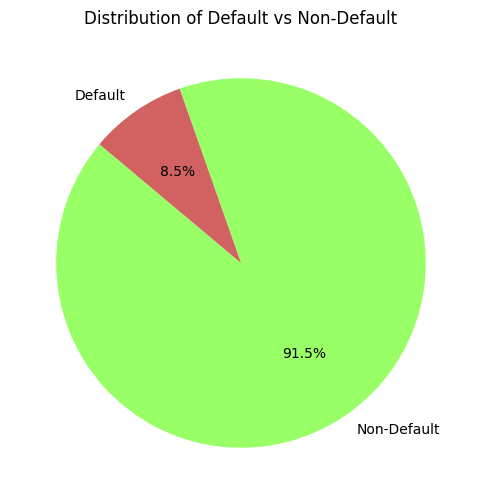

In [305]:
## Additional data cleaning

# James
# Understading the target variable Default where default is when ClearDate is greater than 2025-12-15 and LoanBalance is greater than 0
defaulters = ((df['ClearDate'] < '2025-12-15') & (df['LoanBalance'] > 0)).astype(int)
print("Number of defaulters:", defaulters.sum())

# Calculate the percentage of defaults vs non-defaults
default_counts = defaulters.value_counts(normalize=True) * 100
print("Percentage of Defaults vs Non-Defaults:\n", default_counts)

# Visualize the distribution of the target variable as a pie chart
plt.figure(figsize=(6, 6))
plt.pie(default_counts, labels=['Non-Default', 'Default'], autopct='%1.1f%%', startangle=140, colors=["#99ff66","#d26161"])
plt.title('Distribution of Default vs Non-Default')
plt.show()

# Heatmap

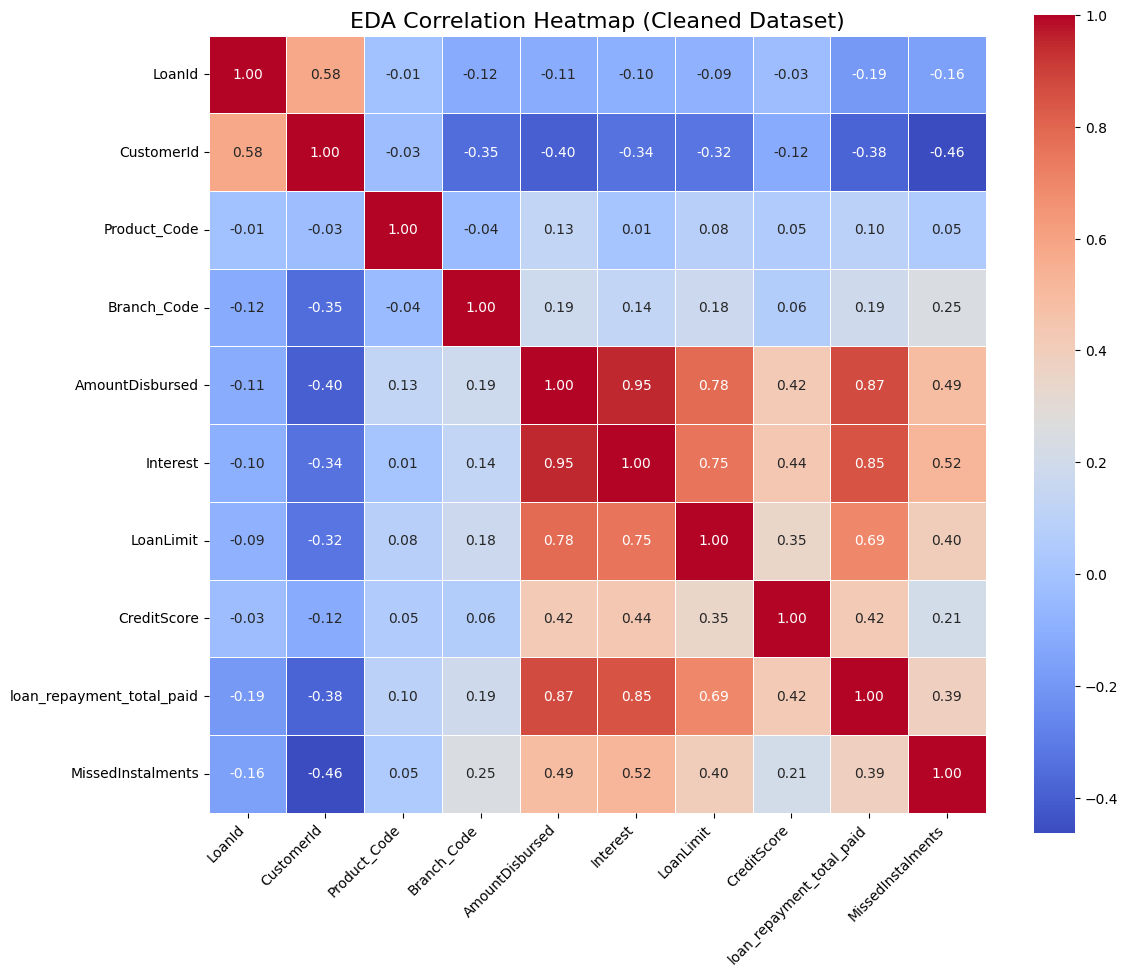

In [306]:
# Convert categorical columns to numerical codes
df['Product_Code'] = df['Product'].astype('category').cat.codes
df['Branch_Code'] = df['Branch'].astype('category').cat.codes

# Columns to include in the heatmap
target_cols = [
    'LoanId', 'CustomerId', 'Product_Code', 'Branch_Code',
    'AmountDisbursed', 'Interest', 'LoanLimit', 'CreditScore',
    'loan_repayment_total_paid', 'MissedInstalments'
]

# Calculate the correlation matrix
corr_matrix = df[target_cols].corr()

# Heatmap visualization
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5, square=True)

plt.title('EDA Correlation Heatmap (Cleaned Dataset)', fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Print and save the heatmap
plt.savefig('correlation_heatmap_cleaned.png')
plt.show()

# Frequency between interest, loan limit, miss installment

Text(0.5, 0, 'Interest')

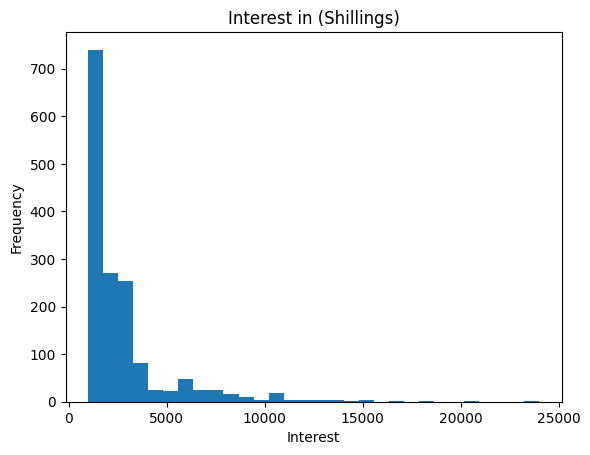

In [307]:
# Nana, Amr

#Plotting Interests in Shillings to check its frequency histogram
ax=df['Interest'].plot(kind='hist'
                      , bins=30, 
                      title= 'Interest in (Shillings)')
ax.set_xlabel ('Interest')

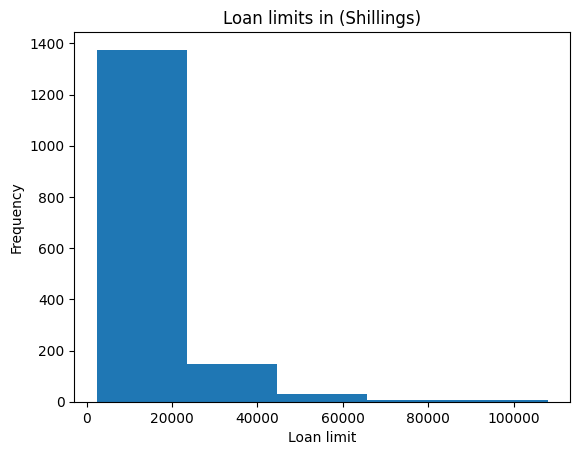

In [308]:
# Nana, Amr
#Plotting (loan limit) to check its frequency histogram.
#The value here are scaled from the csv
ax=df['LoanLimit'].plot(kind='hist'
                      , bins=5, 
                      title= 'Loan limits in (Shillings)')

ax.set_xlabel ('Loan limit')
plt.show()

#I am trying to understand why they are scaled ? and what do the scaled values reflect?

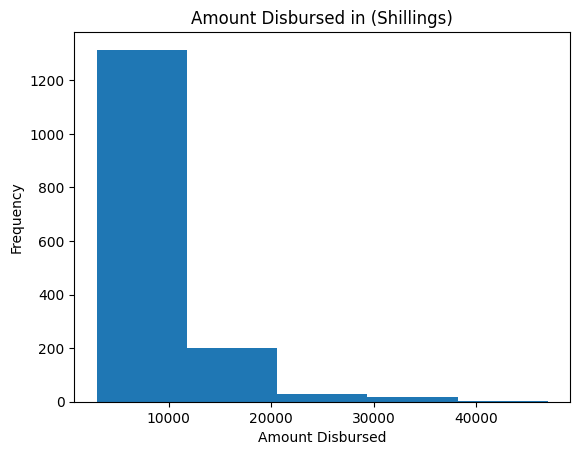

In [309]:
# Nana, Amr
#Plotting (amount disbursed) to check its frequency histogram.

ax=df['AmountDisbursed'].plot(kind='hist'
                      , bins=5, 
                      title= 'Amount Disbursed in (Shillings)')

ax.set_xlabel ('Amount Disbursed')
plt.show()

# Hypothesis 01. 
### Woman has high risk to make default micro finance due to restricted social power

Conclusion: Company has 131 more male client than female client, while few female clients have higher interest amount than male.

Question: Does it mean female client tend to borrow high amount of loan?

<BarContainer object of 2 artists>

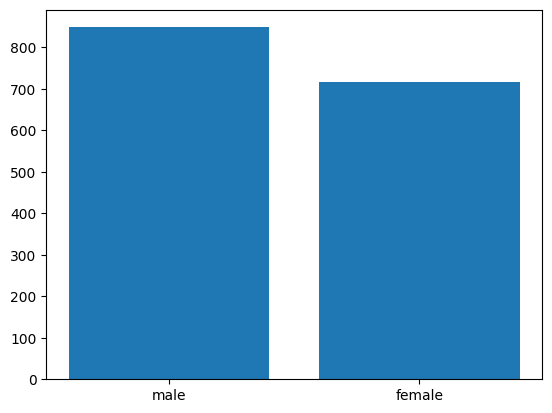

In [310]:
## Nana
gender_counts = df['Gender'].value_counts()
plt.bar(gender_counts.index, gender_counts.values)

Gender
male      848
female    717
Name: count, dtype: int64

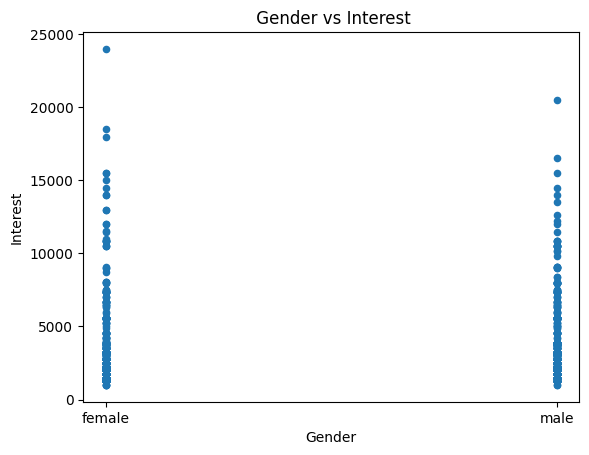

In [311]:
# Amr

#Plotting interest vs Gender to check if the gender affects the amount of interst directly or indirectly.
df.plot (kind='scatter', x= 'Gender' , y = 'Interest' , title = ' Gender vs Interest')
# Most women tend to have interest lower than 10K.
# Most men have interest up to 15K
# Interest higher than 15K is rare for both genders

df['Gender'].value_counts()


# Hypothesis 02. Customer who has high credit score makes less miss instalments

Conclusion : This suggests that high credit scores do not necessarily correlate with lower missed instalments.
High credit scores are also associated with higher average missed instalments as the amount of loan is higher than lower credit scores.

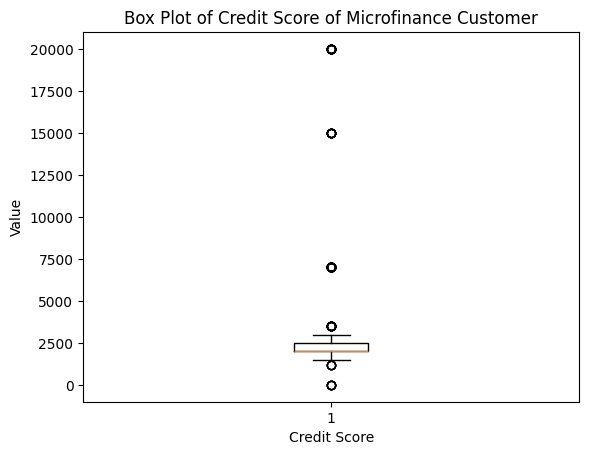

In [312]:
# Nana - Box plot of Credit Score to identify outliers and distribution
plt.boxplot(df['CreditScore'])

plt.xlabel('Credit Score')
plt.ylabel('Value')
plt.title('Box Plot of Credit Score of Microfinance Customer')

plt.show()

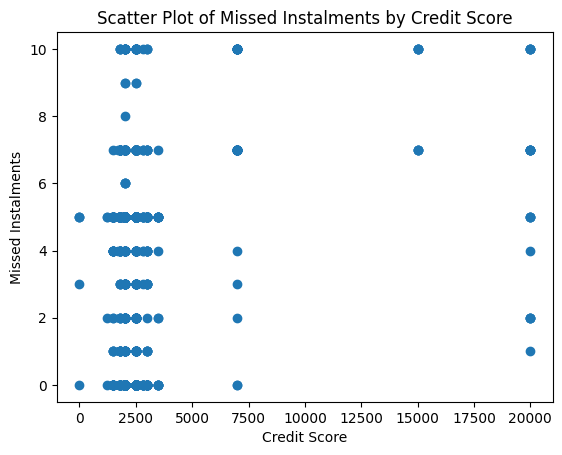

In [313]:
# Nana
# Scatter plots 

plt.scatter(df['CreditScore'], df['MissedInstalments'])

plt.xlabel('Credit Score')
plt.ylabel('Missed Instalments')
plt.title('Scatter Plot of Missed Instalments by Credit Score')

plt.show()

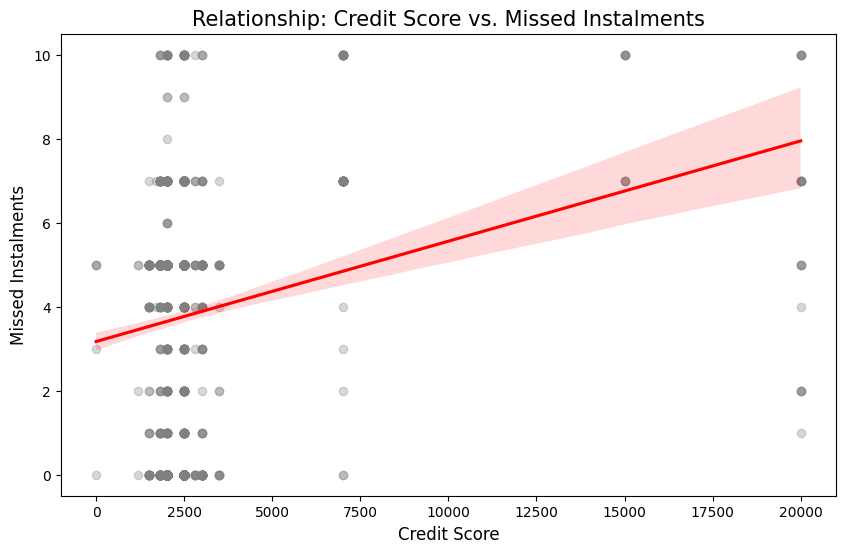

In [314]:
# Sumin
# Visualization: Scatter plot with regression line - Credit Score vs. Missed Instalments
plt.figure(figsize=(10, 6))
sns.regplot(data=df, x='CreditScore', y='MissedInstalments', 
            scatter_kws={'alpha':0.3, 'color':'gray'}, line_kws={'color':'red'})

plt.title('Relationship: Credit Score vs. Missed Instalments', fontsize=15)
plt.xlabel('Credit Score', fontsize=12)
plt.ylabel('Missed Instalments', fontsize=12)
plt.show()

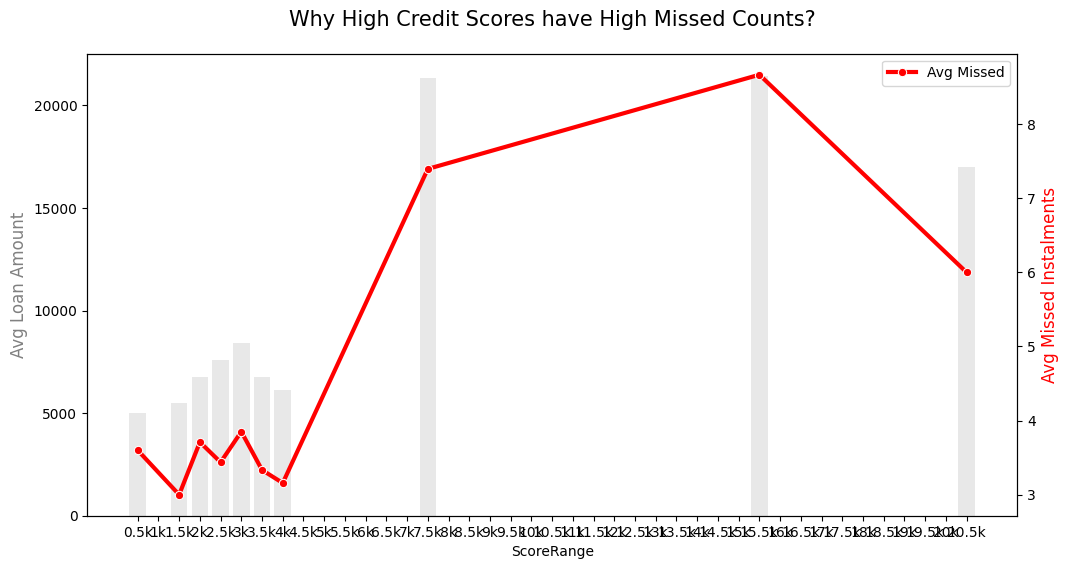

In [315]:
# Sumin - Does high credit score correlate with lower missed instalments?
# What can be read : 
# High credit scores are associated with higher average loan amounts.
# High credit scores are also associated with higher average missed instalments as the amount of loan is higher than lower credit scores.
# This suggests that high credit scores do not necessarily correlate with lower missed instalments.

# 1. Data preparation
bins = range(0, int(df['CreditScore'].max()) + 501, 500)
labels = [f'{b/1000:g}k' for b in bins[1:]]
df['ScoreRange'] = pd.cut(df['CreditScore'], bins=bins, labels=labels, right=False)

# 2. Average per group
analysis = df.groupby('ScoreRange', observed=True).agg({
    'MissedInstalments': 'mean',
    'AmountDisbursed': 'mean',
}).reset_index()

# 3. Visualization: Bar and Line Plot
fig, ax1 = plt.subplots(figsize=(12, 6))

# Bar chart: Loan Amount (background)
sns.barplot(data=analysis, x='ScoreRange', y='AmountDisbursed', color='lightgray', alpha=0.5, ax=ax1)
ax1.set_ylabel('Avg Loan Amount', fontsize=12, color='gray')

# Line plot: Missed Instalments (foreground)
ax2 = ax1.twinx()
sns.lineplot(data=analysis, x='ScoreRange', y='MissedInstalments', color='red', marker='o', linewidth=3, ax=ax2, label='Avg Missed')
ax2.set_ylabel('Avg Missed Instalments', fontsize=12, color='red')

plt.title('Why High Credit Scores have High Missed Counts?', fontsize=15, pad=20)
plt.show()

# Hypothesis 03. The more client has ability to pay off(istead of making default micro finance), they will choose 5 weeks credit ease product.
as they are able to pay off in short term. ( 5 weeks > 10 weeks )


The 5-week credit ease product is the most popular and has the largest number of defaults in absolute terms due to its large customer base.

However, when considering the proportion of clients within each product, the 10-week credit ease product shows a higher frequency of missed instalments compared to the 5-week and 7-week products.

The 7-week credit ease product has the highest default rate among all products.

Overall, clients using the 5-week credit ease product tend to have lower default risk in microfinance, while the 7-week and 10-week products are associated with higher credit risk.

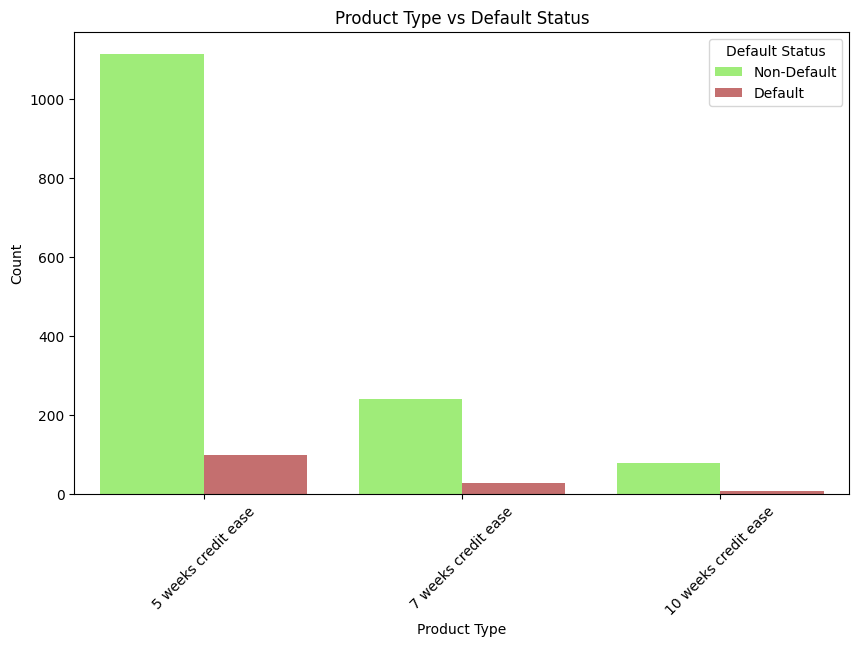

In [316]:
# James

# Analyze relationships between Product and the default
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='Product', hue=defaulters, palette=["#99ff66","#d26161"])
plt.title('Product Type vs Default Status')
plt.xlabel('Product Type')
plt.ylabel('Count')
plt.legend(title='Default Status', labels=['Non-Default', 'Default'])
plt.xticks(rotation=45)
plt.show()

/var/folders/l1/c99z4mxd4ys7m4330g1z_lcc0000gn/T/ipykernel_71794/2006557739.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=product_risk, x='MissedInstalments', y='Product', palette='Reds_r')


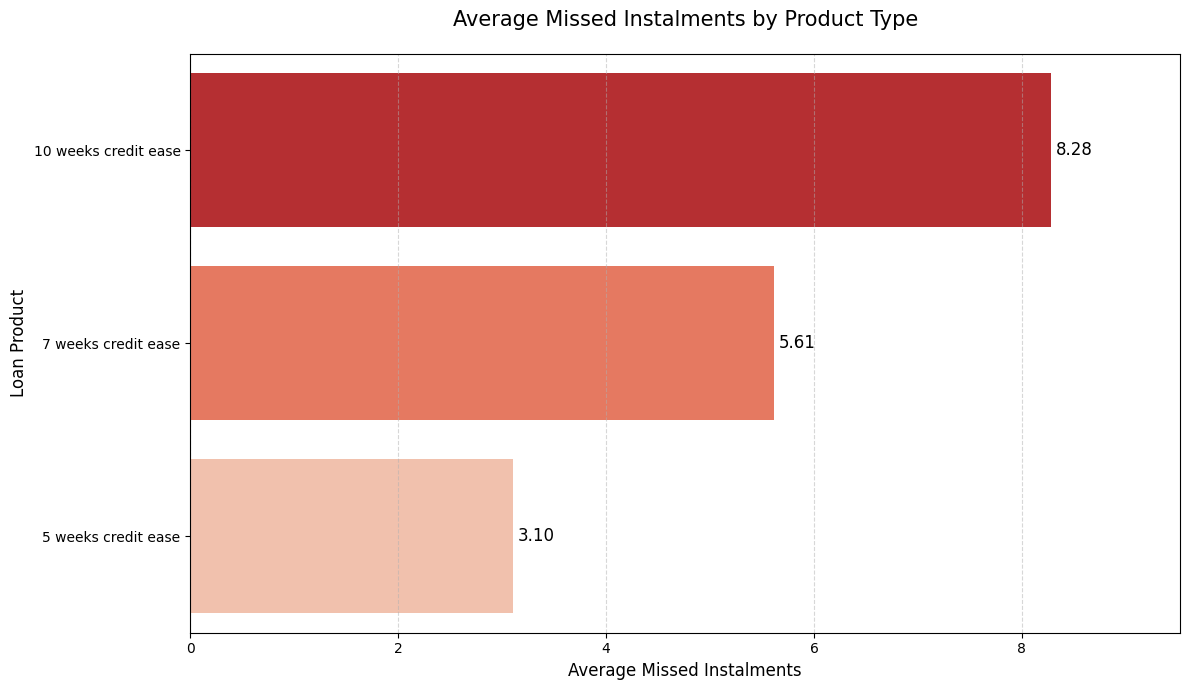

In [317]:
# Sumin - Average Missed Instalments by product
# 10 weeks credit ease has the highest average missed instalments
# Question: Why do clients opting for '10 weeks credit ease' tend to have higher missed instalments compared to other products?

# Visualization: Average Missed Instalments by product -> to detact Risky clients
product_risk = df.groupby('Product')['MissedInstalments'].mean().sort_values(ascending=False).reset_index()

# Visualization: Bar plot
plt.figure(figsize=(12, 7))
ax = sns.barplot(data=product_risk, x='MissedInstalments', y='Product', palette='Reds_r')


for i, p in enumerate(ax.patches):
    width = p.get_width()
    ax.text(width + 0.05,     
            p.get_y() + p.get_height()/2,
            f'{width:.2f}', 
            va='center',    
            fontsize=12, 
            fontweight='regular')

plt.title('Average Missed Instalments by Product Type', fontsize=15, pad=20)
plt.xlabel('Average Missed Instalments', fontsize=12)
plt.ylabel('Loan Product', fontsize=12)

plt.xlim(0, product_risk['MissedInstalments'].max() * 1.15)
plt.grid(axis='x', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

/var/folders/l1/c99z4mxd4ys7m4330g1z_lcc0000gn/T/ipykernel_71794/3783502285.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


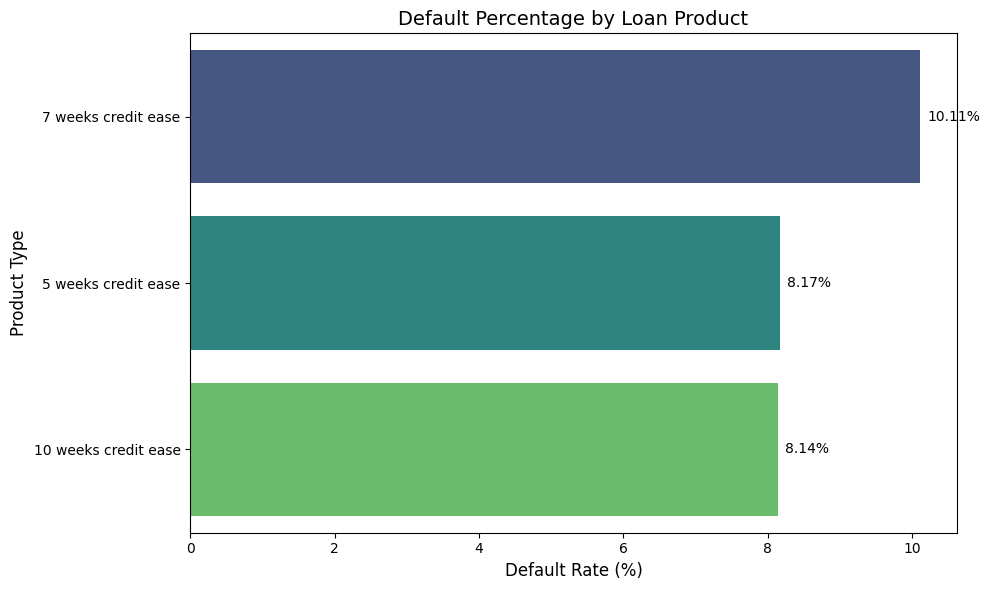

In [318]:
# James
# Introduce bool (1,0) for isDefault
df['IsDefault'] = defaulters

# Calculate default percentages per product type
# Group by Product and take the mean of the 'IsDefault' column
product_defaults = df.groupby('Product')['IsDefault'].mean().reset_index()
product_defaults['Default Percentage'] = product_defaults['IsDefault'] * 100

# Sort the data (descending) so the riskiest products are at the top
product_defaults = product_defaults.sort_values(by='Default Percentage', ascending=False)

# Plot the bar chart
plt.figure(figsize=(10, 6))
sns.barplot(
    x='Default Percentage', 
    y='Product', 
    data=product_defaults, 
    palette='viridis'
)
plt.title('Default Percentage by Loan Product', fontsize=14)
plt.xlabel('Default Rate (%)', fontsize=12)
plt.ylabel('Product Type', fontsize=12)

# Add the actual percentage text next to each bar
for index, value in enumerate(product_defaults['Default Percentage']):
    plt.text(value + 0.1, index, f'{value:.2f}%', va='center')

plt.tight_layout()
plt.show()

/var/folders/l1/c99z4mxd4ys7m4330g1z_lcc0000gn/T/ipykernel_71794/1672467839.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=product_stats, x='Product', y='AvgBalance', palette='Blues_r', ax=ax1, alpha=0.7)


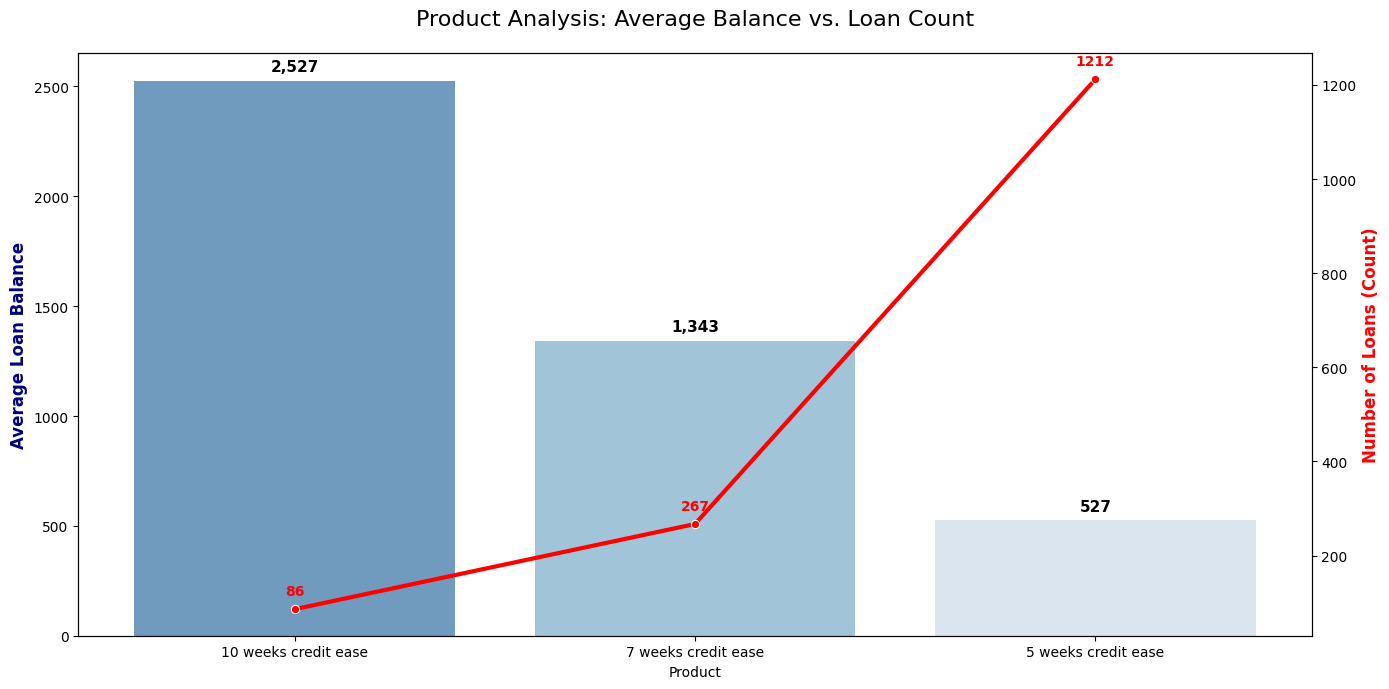

In [319]:
# Sumin - showing 10 weeks credit ease client tend to loan high amount but less clients.

# Calculate product statistics
product_stats = df.groupby('Product').agg(
    LoanCount=('LoanId', 'count'),
    AvgBalance=('LoanBalance', 'mean')
).sort_values(by='AvgBalance', ascending=False).reset_index()

# Visualization: Average Balance vs. Loan Count by Product
fig, ax1 = plt.subplots(figsize=(14, 7))

# Average Balance (Bar Chart)
sns.barplot(data=product_stats, x='Product', y='AvgBalance', palette='Blues_r', ax=ax1, alpha=0.7)
ax1.set_ylabel('Average Loan Balance', fontsize=12, fontweight='bold', color='navy')
ax1.set_title('Product Analysis: Average Balance vs. Loan Count', fontsize=16, pad=20)

# Number labels on top of bars
for p in ax1.patches:
    ax1.annotate(f'{p.get_height():,.0f}', 
                 (p.get_x() + p.get_width() / 2., p.get_height()), 
                 ha='center', va='center', xytext=(0, 10), 
                 textcoords='offset points', fontsize=11, fontweight='bold')

# number of Loans (Line Chart - Dual Axis)
ax2 = ax1.twinx() 
sns.lineplot(data=product_stats, x='Product', y='LoanCount', color='red', marker='o', linewidth=3, ax=ax2)
ax2.set_ylabel('Number of Loans (Count)', fontsize=12, fontweight='bold', color='red')

# Annotate Loan Count values
for i, txt in enumerate(product_stats['LoanCount']):
    ax2.annotate(txt, (product_stats['Product'][i], product_stats['LoanCount'][i]), 
                 textcoords="offset points", xytext=(0,10), ha='center', color='red', fontweight='bold')

plt.tight_layout()
plt.show()

# Hypothesis 04. The more client borrow large amont of loan, the higher possibility to make defaulty.

Conclusion : Contrary to expectations, client who borrow less amount of loan makes much defaulty than who borrow large amont of loan.

/var/folders/l1/c99z4mxd4ys7m4330g1z_lcc0000gn/T/ipykernel_71794/1784705482.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  loan_amount_defaults = df.groupby('LoanAmountBin')['IsDefault'].mean().reset_index()
/var/folders/l1/c99z4mxd4ys7m4330g1z_lcc0000gn/T/ipykernel_71794/1784705482.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


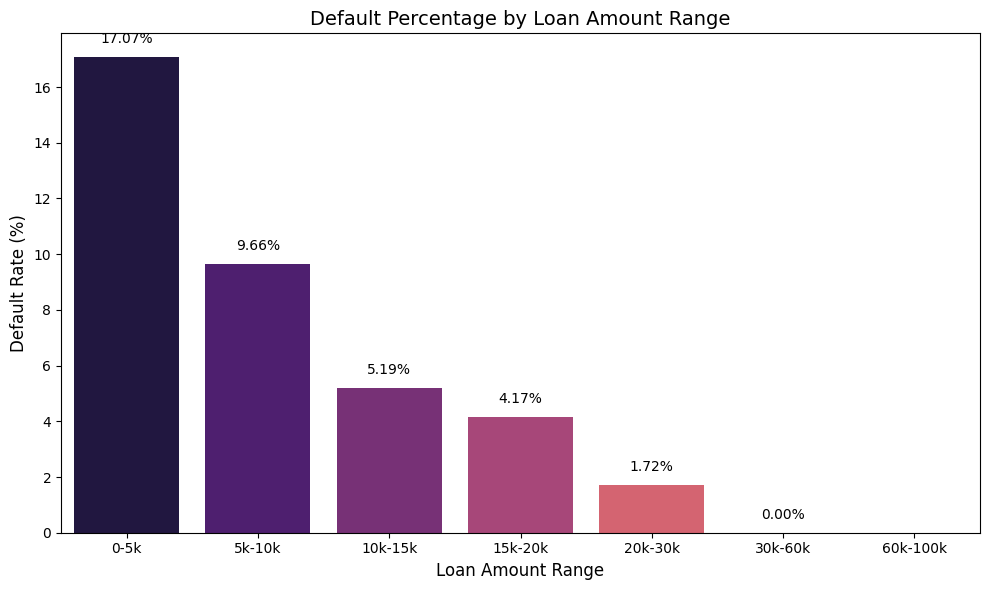

In [320]:
# James

# Analyze relationship between LoanAmount and IsDefault using a binned bar plot for differet loan ranges
# Define bins and labels for loan amounts
bins = [0, 5000, 10000, 15000, 20000, 30000, 60000, 100000] 
labels = ['0-5k', '5k-10k', '10k-15k', '15k-20k', '20k-30k', '30k-60k', '60k-100k']

# Create a new column for binned loan amounts
df['LoanAmountBin'] = pd.cut(df['AmountDisbursed'], bins=bins, labels=labels, right=False)

# Calculate the average default rate for each range
loan_amount_defaults = df.groupby('LoanAmountBin')['IsDefault'].mean().reset_index()
loan_amount_defaults['Default Percentage'] = loan_amount_defaults['IsDefault'] * 100
# Plot the bar chart
plt.figure(figsize=(10, 6))
sns.barplot(
    x='LoanAmountBin', 
    y='Default Percentage', 
    data=loan_amount_defaults, 
    palette='magma'
)
plt.title('Default Percentage by Loan Amount Range', fontsize=14)
plt.xlabel('Loan Amount Range', fontsize=12)
plt.ylabel('Default Rate (%)', fontsize=12)
# Add the actual percentage text above each bar
for index, value in enumerate(loan_amount_defaults['Default Percentage']):
    plt.text(index, value + 0.5, f'{value:.2f}%', ha='center')  
plt.tight_layout()
plt.show()


# Hypothesis 05. Risk of default micro finance is different by branch as their lifestlye, quality of life, average salary might be different.

Conclusion : Molo has higher miss instalments rate than Engineer, while default rate is lower than Engineer
** Good to look into why miss instalments doesn't have strong correlation with default at the end.

--- Default Rates by Branch (%) ---
Branch
engineer    18.20
molo         5.03
dtype: float64


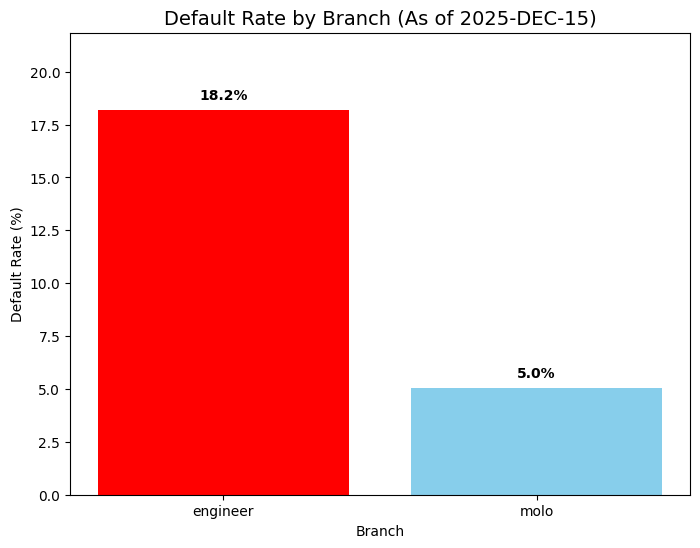

In [321]:
# James
# Visualizing the percentage of defaulters/number of loans based on branch as a chart

# Calculate Default Rate by Branch
branch_stats = defaulters.groupby(df['Branch']).mean() * 100

print("--- Default Rates by Branch (%) ---")
print(branch_stats.round(2))

# Visualization
plt.figure(figsize=(8, 6))
colors = ['red', 'skyblue']

plt.bar(branch_stats.index, branch_stats.values, color=colors)

plt.title('Default Rate by Branch (As of 2025-DEC-15)', fontsize=14)
plt.ylabel('Default Rate (%)')
plt.xlabel('Branch')
plt.ylim(0, max(branch_stats.values) * 1.2) 

for i, v in enumerate(branch_stats.values):
    plt.text(i, v + 0.5, f"{v:.1f}%", ha='center', fontweight='bold')

plt.show()

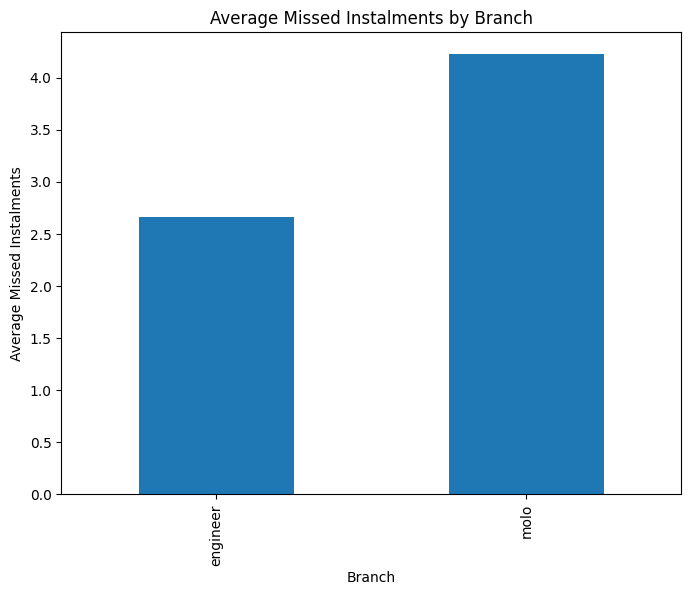

In [322]:
#Group analysis
average_misinstalments_by_branch = df.groupby('Branch')['MissedInstalments'].mean()

plt.figure(figsize=(8, 6))

average_misinstalments_by_branch.plot(kind='bar')

plt.xlabel('Branch')
plt.ylabel('Average Missed Instalments')
plt.title('Average Missed Instalments by Branch')

plt.show()

In [323]:
# ------------------------------------------------
# 5.6 Default Rate by Branch
# Why this feature?
# Branch-level differences may reveal operational, demographic, or portfolio-quality issues.
# Helps identify high-risk locations for intervention.
# The Molo branch shows a much higher default rate than Engineer, suggesting branch-level risk differences worth investigating
# ------------------------------------------------


if "Branch" in df.columns:
    avg_default = df.groupby("Branch")[target_col].mean()

    plt.figure(figsize=(10, 5))
    bars = plt.bar(avg_default.index, avg_default.values, color="steelblue")

    # Add numeric labels
    for bar in bars:
        height = bar.get_height()
        plt.text(
            bar.get_x() + bar.get_width() / 2,
            height,
            f"{height:.2f}",
            ha="center",
            va="bottom",
            fontsize=9
        )

    plt.title("Default Rate by Branch")
    plt.xlabel("Branch")
    plt.ylabel("Default Rate")
    plt.xticks(rotation=45)
    plt.show()

# Hypothesis 06. Frequent client has high risk to make default micro finance.

Conclusion : 
Most clients use this microfinance service only 1–2 times, with very few exceeding 3 uses. Interestingly, clients who have used the product 5–6 times show a higher tendency to default compared to those in the 3–4 times range.

Customer loan counts:
 CustomerId
1048    16
1026    15
484     15
1000    14
1019    13
1013    13
993     12
832     12
1011    11
958     11
931     11
1014    11
611     10
970     10
1058    10
925     10
295     10
1372     9
921      9
872      9
482      9
920      9
798      9
1103     9
969      9
932      9
1395     9
1005     8
415      8
1030     8
1053     8
1043     8
1088     8
917      8
442      8
997      8
1180     8
1066     7
1172     7
1538     7
983      7
851      7
980      7
469      7
444      7
1076     7
714      7
1070     7
1044     7
1086     7
1121     7
650      6
724      6
1431     6
1102     6
573      6
475      6
901      6
1371     6
1207     6
1205     6
381      6
1401     5
1230     5
1226     5
1119     5
569      5
889      5
831      5
1146     5
1407     5
986      5
1039     5
1557     5
1454     5
1077     5
718      5
1072     5
1339     5
948      5
1096     5
994      5
1068     5
1403     5
1476     4
90       4
871      4
1204     

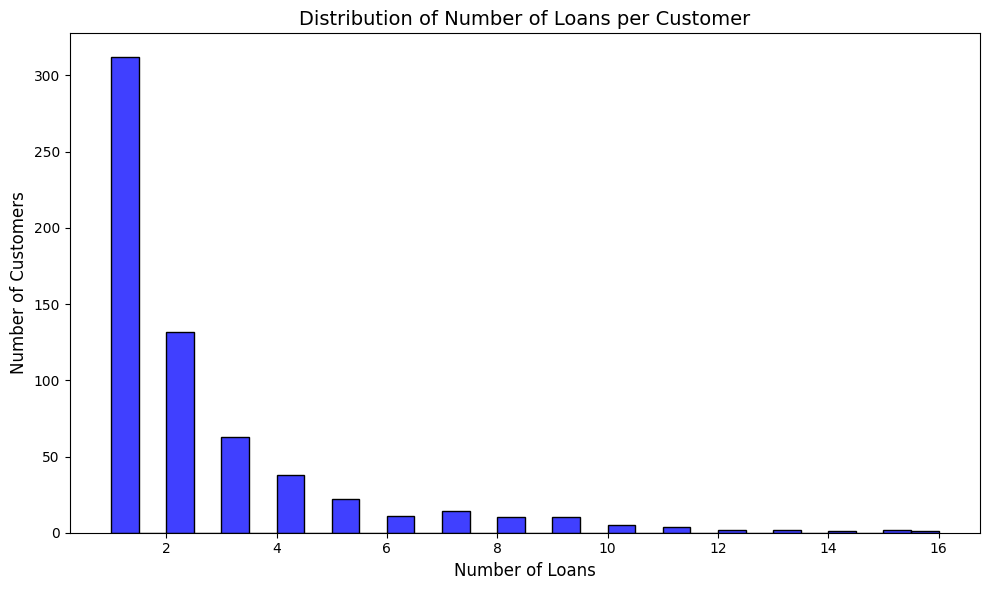

In [324]:
# James

# Get the customer loan counts based on CustomerId and plot as a histogram
customer_loan_counts = df['CustomerId'].value_counts()
print("Customer loan counts:\n", customer_loan_counts)
plt.figure(figsize=(10, 6))
sns.histplot(customer_loan_counts, bins=30, kde=False, color='blue')
plt.title('Distribution of Number of Loans per Customer', fontsize=14)
plt.xlabel('Number of Loans', fontsize=12)
plt.ylabel('Number of Customers', fontsize=12)
plt.tight_layout()
plt.show()

In [325]:
# Get the number of customers with 1 loan
single_loan_customers = customer_loan_counts[customer_loan_counts == 1].count()
print("Number of customers with 1 loan:", single_loan_customers)

Number of customers with 1 loan: 312


/var/folders/l1/c99z4mxd4ys7m4330g1z_lcc0000gn/T/ipykernel_71794/3148774744.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


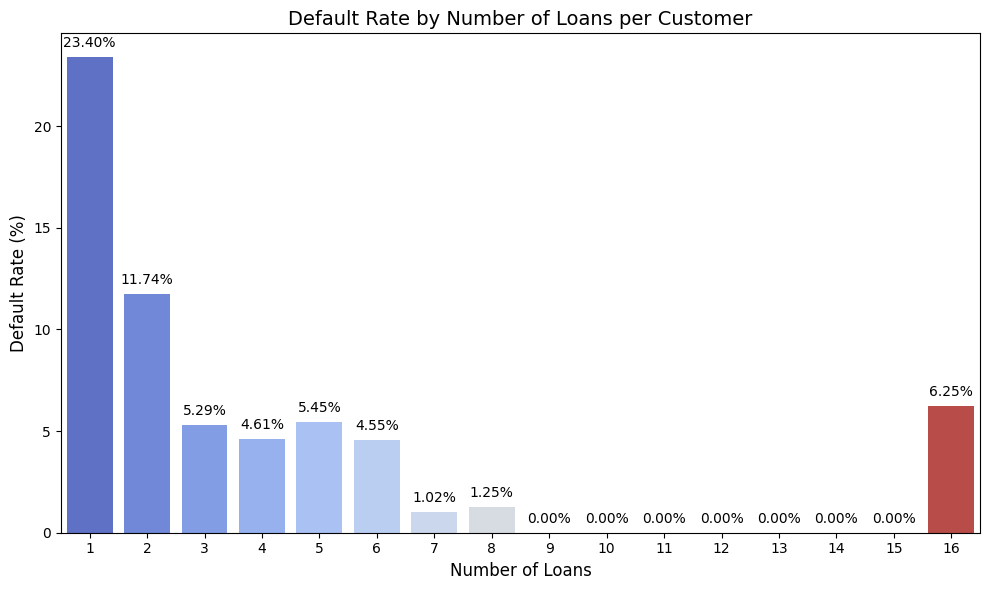

In [326]:
# Visualize the default rate based on the number of loans per customer as a bar plot
loan_count_defaults = df.groupby(df['CustomerId'].map(customer_loan_counts))['IsDefault'].mean().reset_index()
loan_count_defaults.columns = ['Number of Loans', 'Default Rate']
loan_count_defaults['Default Rate'] *= 100  
plt.figure(figsize=(10, 6))
sns.barplot(
    x='Number of Loans', 
    y='Default Rate', 
    data=loan_count_defaults, 
    palette='coolwarm'
)
plt.title('Default Rate by Number of Loans per Customer', fontsize=14)
plt.xlabel('Number of Loans', fontsize=12)
plt.ylabel('Default Rate (%)', fontsize=12)
# Add the actual percentage text above each bar
for index, value in enumerate(loan_count_defaults['Default Rate']):
    plt.text(index, value + 0.5, f'{value:.2f}%', ha='center')
plt.tight_layout()
plt.show()

# Hypothesis 07. If client makes miss instalment or transaction frequently, they have high possibility to make default micro finance.

Conclusion : The frequency of missed installments and transaction counts correlates with the default rate, but the relationship is not linear
1. The highest default rate is among clients with 6 missed installments, while the second highest is surprisingly those with just 1 miss.
2. Clients with 0–4 transactions are at highest risk. Interestingly, risk increases to 13% once transactions exceed 50, whereas the 5–49 range shows the lowest risk.

/var/folders/l1/c99z4mxd4ys7m4330g1z_lcc0000gn/T/ipykernel_71794/3457303589.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


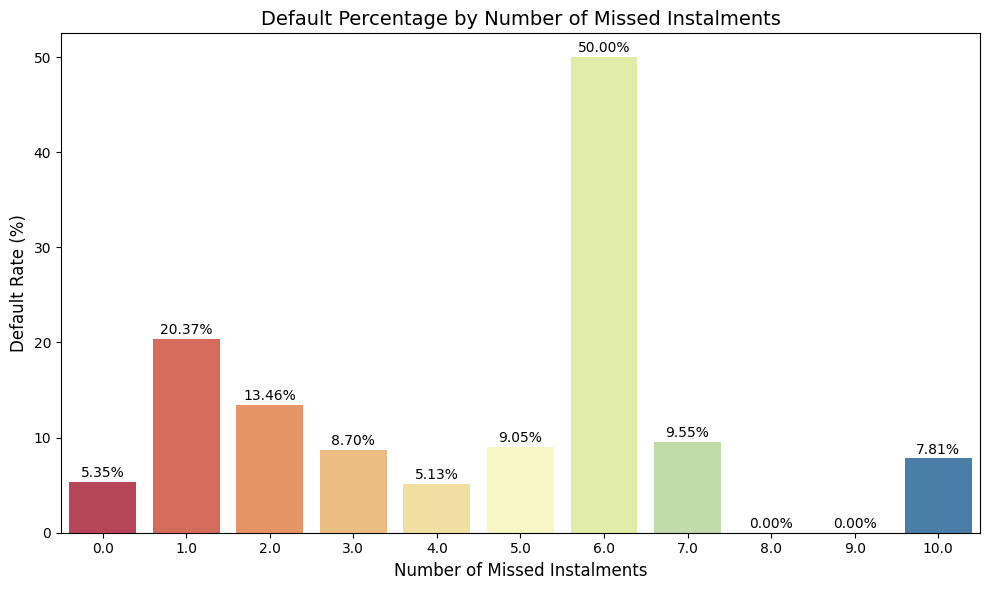

In [327]:
# James

# Visualize the relationship between MissedInstalments and IsDefault using a bar plot
missed_instalment_defaults = df.groupby('MissedInstalments')['IsDefault'].mean().reset_index()
missed_instalment_defaults['Default Percentage'] = missed_instalment_defaults['IsDefault'] * 100
plt.figure(figsize=(10, 6))
sns.barplot(
    x='MissedInstalments', 
    y='Default Percentage', 
    data=missed_instalment_defaults, 
    palette='Spectral'
)
plt.title('Default Percentage by Number of Missed Instalments', fontsize=14)
plt.xlabel('Number of Missed Instalments', fontsize=12)
plt.ylabel('Default Rate (%)', fontsize=12)
# Add the actual percentage text above each bar
for index, value in enumerate(missed_instalment_defaults['Default Percentage']):
    plt.text(index, value + 0.5, f'{value:.2f}%', ha='center')
plt.tight_layout()
plt.show()

/var/folders/l1/c99z4mxd4ys7m4330g1z_lcc0000gn/T/ipykernel_71794/592463311.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  loan_repayment_defaults = df.groupby('LoanRepaymentTxnCountBin')['IsDefault'].mean().reset_index()
/var/folders/l1/c99z4mxd4ys7m4330g1z_lcc0000gn/T/ipykernel_71794/592463311.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


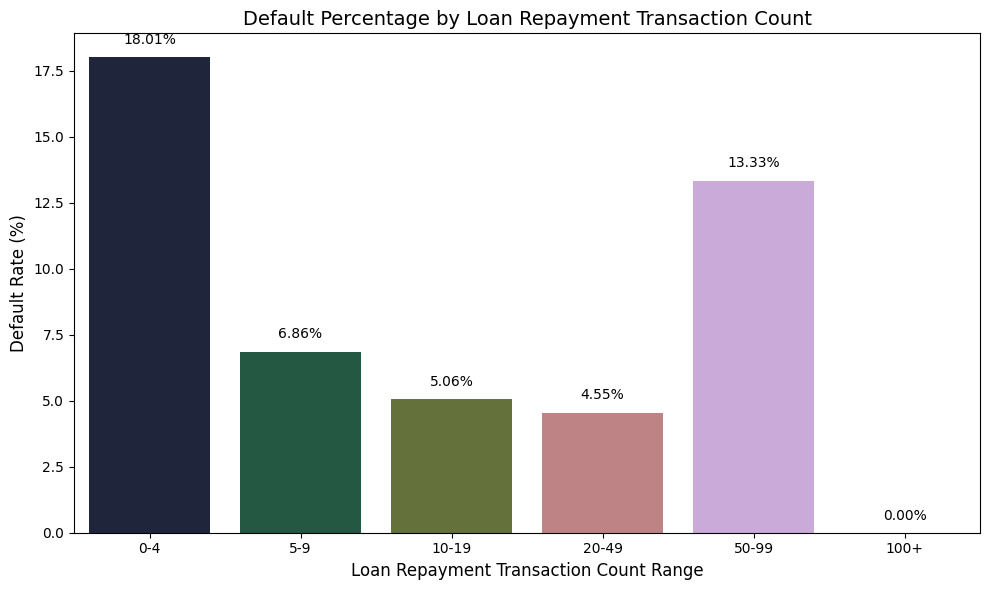

In [328]:
# Visualize the loan_repayment_txn_count against IsDefault using a bar plot in buckets
# Define bins and labels for loan repayment transaction counts
bins = [0, 5, 10, 20, 50, 100, 500]
labels = ['0-4', '5-9', '10-19', '20-49', '50-99', '100+']
# Create a new column for binned loan repayment transaction counts
df['LoanRepaymentTxnCountBin'] = pd.cut(df['loan_repayment_txn_count'], bins=bins, labels=labels, right=False)          
loan_repayment_defaults = df.groupby('LoanRepaymentTxnCountBin')['IsDefault'].mean().reset_index()
loan_repayment_defaults['Default Percentage'] = loan_repayment_defaults['IsDefault'] * 100
plt.figure(figsize=(10, 6))
sns.barplot(
    x='LoanRepaymentTxnCountBin', 
    y='Default Percentage', 
    data=loan_repayment_defaults, 
    palette='cubehelix'
)
plt.title('Default Percentage by Loan Repayment Transaction Count', fontsize=14)
plt.xlabel('Loan Repayment Transaction Count Range', fontsize=12)
plt.ylabel('Default Rate (%)', fontsize=12)
# Add the actual percentage text above each bar
for index, value in enumerate(loan_repayment_defaults['Default Percentage']):
    plt.text(index, value + 0.5, f'{value:.2f}%', ha='center')
plt.tight_layout()
plt.show()

# Hypothesis 08. Does a client's previous loan history significantly affect their likelihood of default?

Conclusion : 
1. Clients who fully cleared their previous loans show a higher default rate than those who had 1–5 missed installments.
2. Risk peaks for Cycle 3–4 clients, whereas the default rate drops significantly for those in Cycles 5–6.

/var/folders/l1/c99z4mxd4ys7m4330g1z_lcc0000gn/T/ipykernel_71794/2147900084.py:28: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  default_rates = history_df.groupby('History_Group')['IsDefault'].mean() * 100
/var/folders/l1/c99z4mxd4ys7m4330g1z_lcc0000gn/T/ipykernel_71794/2147900084.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=default_rates.index, y=default_rates.values, palette='RdYlGn_r') # Red to Green color map


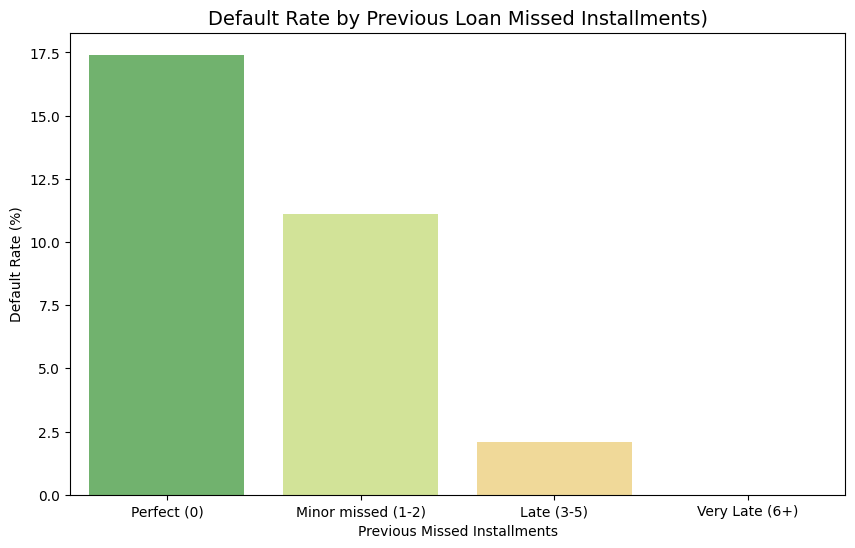

In [329]:
# James

# Sort by Customer and Date to ensure correct order
df = df.sort_values(by=['CustomerId', 'BorrowDate'])

# All loans are at least cycle 2 (the first loan is cycle 1, which we have removed during preprocessing)
# Calculate Loan Cycle (Cycle 2, 3, etc.)
df['Loan_Sequence'] = df.groupby('CustomerId').cumcount() + 2

# Look at the PREVIOUS loan's behavior for each customer
df['Prev_MissedInstalments'] = df.groupby('CustomerId')['MissedInstalments'].shift(1)
df['Prev_TxnCount'] = df.groupby('CustomerId')['loan_repayment_txn_count'].shift(1)

# We remove the first loan for each customer because they have no history to analyze
history_df = df.dropna(subset=['Prev_MissedInstalments', 'Prev_TxnCount']).copy()

# Visualize the relationship between previous missed installments and current default rate

plt.figure(figsize=(10, 6))

# Bin the missed installments into groups
# Groups of bins (perfect - no missed, minor missed, late, very late)
history_df['History_Group'] = pd.cut(history_df['Prev_MissedInstalments'], 
                                     bins=[-1, 0, 2, 5, 100], 
                                     labels=['Perfect (0)', 'Minor missed (1-2)', 'Late (3-5)', 'Very Late (6+)'])

# Calculate Default Rate per group
default_rates = history_df.groupby('History_Group')['IsDefault'].mean() * 100

# Plot
sns.barplot(x=default_rates.index, y=default_rates.values, palette='RdYlGn_r') # Red to Green color map
plt.title('Default Rate by Previous Loan Missed Installments)', fontsize=14)
plt.ylabel('Default Rate (%)')
plt.xlabel('Previous Missed Installments')
plt.show()

/var/folders/l1/c99z4mxd4ys7m4330g1z_lcc0000gn/T/ipykernel_71794/4052418450.py:9: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot_table = history_df.pivot_table(index='Txn_Group', columns='History_Group', values='IsDefault', aggfunc='mean') * 100


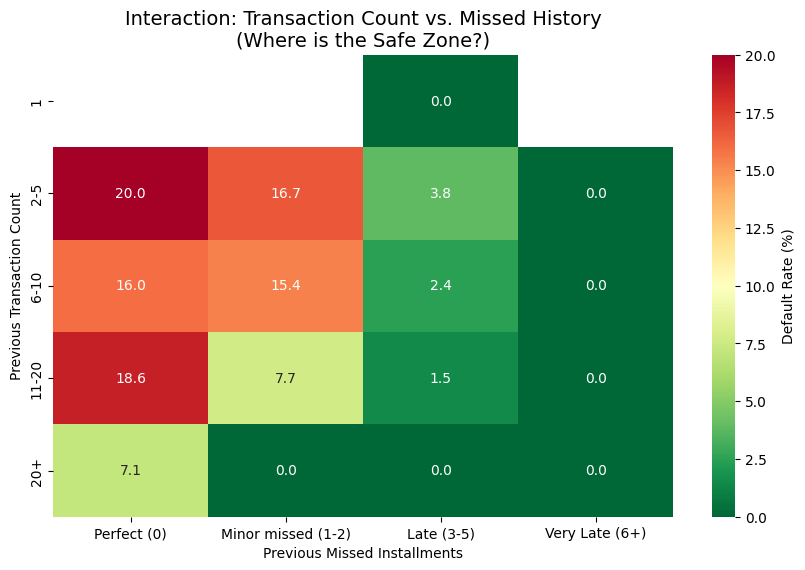

In [330]:
# Interaction: Transaction Count vs. Missed History Heatmap

# Bin Transaction Counts
history_df['Txn_Group'] = pd.cut(history_df['Prev_TxnCount'], 
                                 bins=[0, 1, 5, 10, 20, 100], 
                                 labels=['1', '2-5', '6-10', '11-20', '20+'])

# Create Pivot Table
pivot_table = history_df.pivot_table(index='Txn_Group', columns='History_Group', values='IsDefault', aggfunc='mean') * 100

# Plot Heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(pivot_table, annot=True, fmt=".1f", cmap='RdYlGn_r', cbar_kws={'label': 'Default Rate (%)'})
plt.title('Interaction: Transaction Count vs. Missed History\n(Where is the Safe Zone?)', fontsize=14)
plt.ylabel('Previous Transaction Count')
plt.xlabel('Previous Missed Installments')

plt.show()

/var/folders/l1/c99z4mxd4ys7m4330g1z_lcc0000gn/T/ipykernel_71794/619619442.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  late_risk = history_df[history_df['Is_Late']].groupby('Sequence_Group')['IsDefault'].mean() * 100


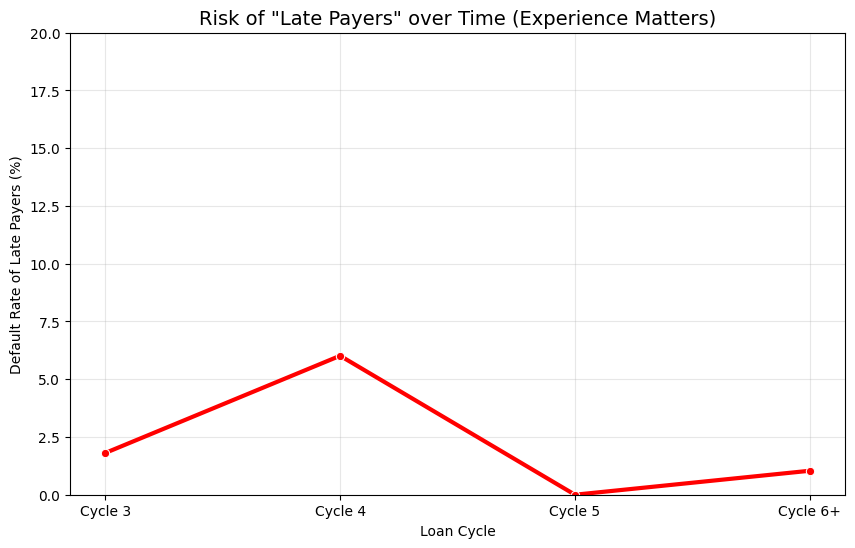

In [331]:
# Experience: Loan Cycle vs. Late Payers Line Plot
# Bin Loan Sequence
history_df['Sequence_Group'] = pd.cut(history_df['Loan_Sequence'], 
                                      bins=[1.9, 2.9, 3.9, 4.9, 5.9, 100], 
                                      labels=['Cycle 2', 'Cycle 3', 'Cycle 4', 'Cycle 5', 'Cycle 6+'])

# Flag Late Payers
history_df['Is_Late'] = history_df['Prev_MissedInstalments'] > 0

# Calculate Risk ONLY for Late Payers
late_risk = history_df[history_df['Is_Late']].groupby('Sequence_Group')['IsDefault'].mean() * 100

# Plot
plt.figure(figsize=(10, 6))
sns.lineplot(x=late_risk.index, y=late_risk.values, marker='o', color='red', linewidth=3)
plt.title('Risk of "Late Payers" over Time (Experience Matters)', fontsize=14)
plt.ylabel('Default Rate of Late Payers (%)')
plt.xlabel('Loan Cycle')
plt.ylim(0, 20) # Set limit to see the drop clearly
plt.grid(True, alpha=0.3)
plt.show()

# Hypothesis 09. Do Late Payers have higher capacity?

Conclusion : Most of clients make late payment than perfect weekly payment. cliente who has higher Loan limite tend to make late payment.

/var/folders/l1/c99z4mxd4ys7m4330g1z_lcc0000gn/T/ipykernel_71794/1787084686.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Payer_Style', y='LoanLimit', data=history_df, palette='Set2')


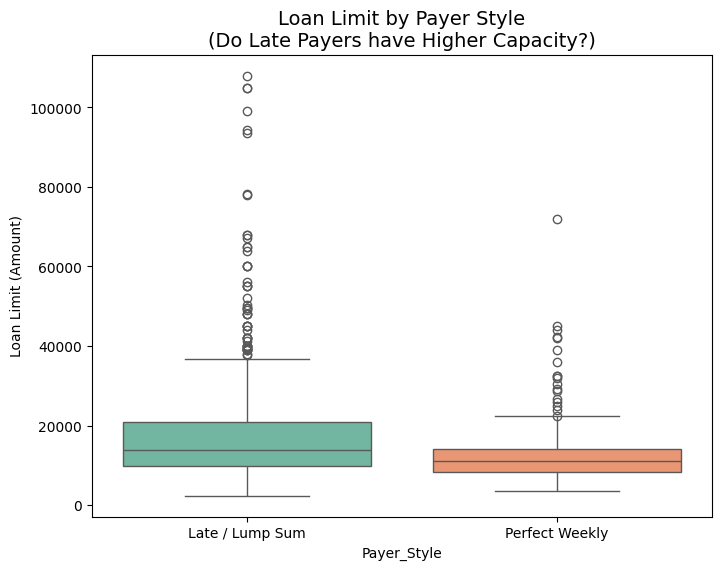

In [332]:
# James

# Capacity: Loan Limit vs. Payer Style Box Plot

# Define Payer Style
history_df['Payer_Style'] = history_df['Prev_MissedInstalments'].apply(lambda x: 'Late / Lump Sum' if x > 0 else 'Perfect Weekly')

# Plot
plt.figure(figsize=(8, 6))
sns.boxplot(x='Payer_Style', y='LoanLimit', data=history_df, palette='Set2')
plt.title('Loan Limit by Payer Style\n(Do Late Payers have Higher Capacity?)', fontsize=14)
plt.ylabel('Loan Limit (Amount)')
plt.show()

# Hypothesis 10. Does business type impact to make defaulty?

Conclusion : 
1. Top 25% clients who has high credit score but has many missed instalments tend to borrow big amount of loan than others customers.
2. Agriculture, green grocery business owener has higher risk to make defaulty (but cannot generalized)

/var/folders/l1/c99z4mxd4ys7m4330g1z_lcc0000gn/T/ipykernel_71794/1474997351.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=high_risk_prime, y='BusinessType',


High credit score but missed instalments clients: 503


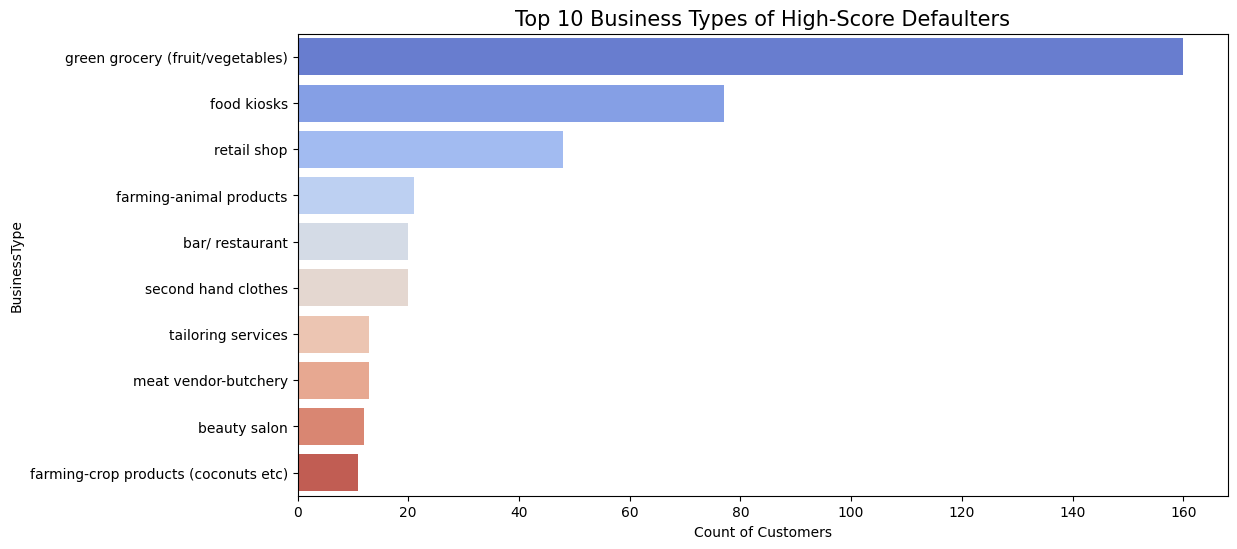

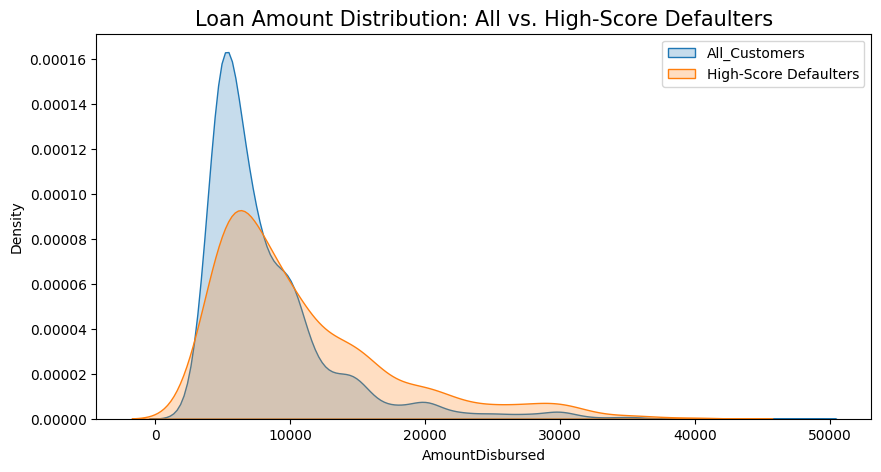

In [333]:
# Sumin

# High Credit Score but High Missed Instalments Analysis
high_score_threshold = df['CreditScore'].quantile(0.75)  # Top 25% credit score
high_missed_threshold = df['MissedInstalments'].mean()   # Average missed instalments

high_risk_prime = df[(df['CreditScore'] >= high_score_threshold) & 
                     (df['MissedInstalments'] > high_missed_threshold)].copy()

print(f"High credit score but missed instalments clients: {len(high_risk_prime)}")

# Visualization their business types
plt.figure(figsize=(12, 6))
sns.countplot(data=high_risk_prime, y='BusinessType', 
              order=high_risk_prime['BusinessType'].value_counts().iloc[:10].index,
              palette='coolwarm')

plt.title('Top 10 Business Types of High-Score Defaulters', fontsize=15)
plt.xlabel('Count of Customers')
plt.show()

# Visualization: Loan Amount Distribution - All vs. High-Score Defaulters
plt.figure(figsize=(10, 5))
sns.kdeplot(df['AmountDisbursed'], label='All_Customers', fill=True)
sns.kdeplot(high_risk_prime['AmountDisbursed'], label='High-Score Defaulters', fill=True)

plt.title('Loan Amount Distribution: All vs. High-Score Defaulters', fontsize=15)
plt.legend()
plt.show()

--- Industry Summary Statistics ---
                                  Avg_Loan_Amount  Avg_Repayment_Days  \
Industry                                                                
education                            20000.000000           77.500000   
transportation                       10119.047619           54.404762   
wholesale & retail trade              9324.324324           36.918919   
manufacturing                         9285.714286           36.142857   
fashion & beauty products             8923.566879           43.184713   
agriculture                           8369.230769           45.892308   
food & hospitality                    8288.190683           43.643554   
automobile services                   8222.222222           23.333333   
business & information                8142.857143           53.285714   
natural resources/environmental       7837.837838           34.837838   
agriculture, forestry & fishing       7814.814815           37.370370   
real estate & h

/var/folders/l1/c99z4mxd4ys7m4330g1z_lcc0000gn/T/ipykernel_71794/2426686687.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=df, x='Industry', y='RepaymentDuration', palette='viridis', errorbar=None)


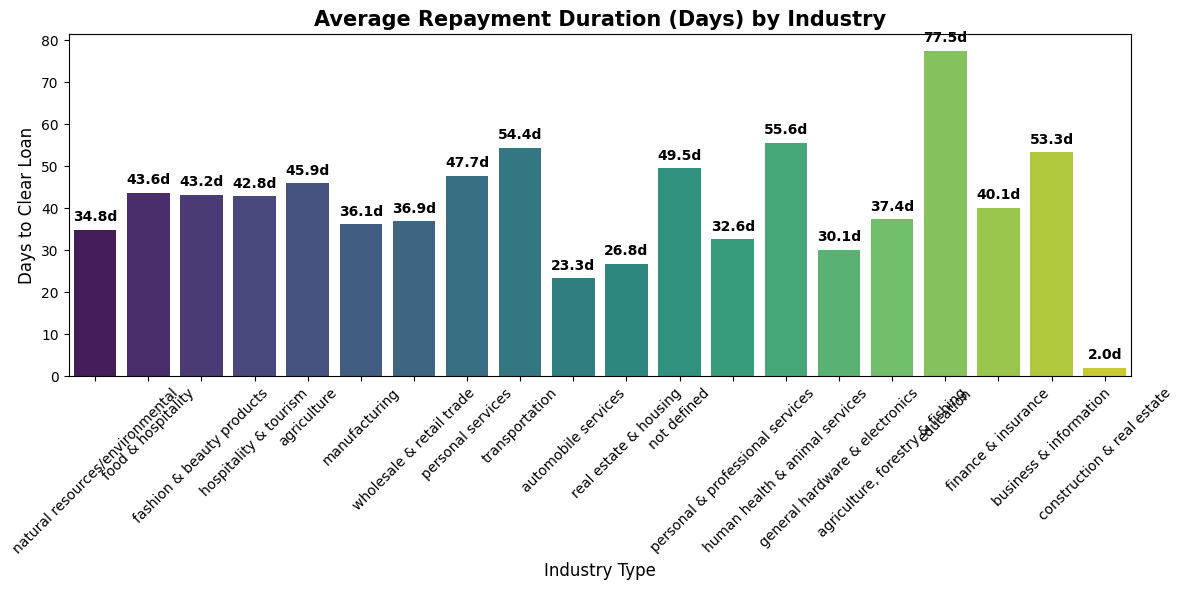

In [334]:
# 1. Feature Engineering: Calculating Repayment Duration
# Converting to datetime to ensure accurate calculation
df['BorrowDate'] = pd.to_datetime(df['BorrowDate'])
df['ClearDate'] = pd.to_datetime(df['ClearDate'])

# Repayment duration in days
df['RepaymentDuration'] = (df['ClearDate'] - df['BorrowDate']).dt.days

# 2. Aggregating Statistics by Industry
# We analyze the average loan size, repayment speed, and total volume
industry_summary = df.groupby('Industry').agg({
    'AmountDisbursed': 'mean',
    'RepaymentDuration': 'mean',
    'LoanId': 'count'
}).rename(columns={
    'AmountDisbursed': 'Avg_Loan_Amount',
    'RepaymentDuration': 'Avg_Repayment_Days',
    'LoanId': 'Total_Loan_Count'
}).sort_values(by='Avg_Loan_Amount', ascending=False)

print("--- Industry Summary Statistics ---")
print(industry_summary)

# 3. Visualization: Average Repayment Duration by Industry
# Bar chart to compare how long each industry takes to clear their debt
plt.figure(figsize=(12, 6))
ax = sns.barplot(data=df, x='Industry', y='RepaymentDuration', palette='viridis', errorbar=None)

# Adding value labels on top of the bars for clarity
for p in ax.patches:
    ax.annotate(f'{p.get_height():.1f}d', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', xytext=(0, 9), 
                textcoords='offset points', fontsize=10, fontweight='bold')

plt.xticks(rotation=45)
plt.title('Average Repayment Duration (Days) by Industry', fontsize=15, fontweight='bold')
plt.xlabel('Industry Type', fontsize=12)
plt.ylabel('Days to Clear Loan', fontsize=12)

plt.tight_layout()
plt.savefig('industry_repayment_duration.png', dpi=300, bbox_inches='tight')
plt.show()

/var/folders/l1/c99z4mxd4ys7m4330g1z_lcc0000gn/T/ipykernel_71794/3401517482.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=business_analysis.head(10), x='Default_Clients', y='BusinessType', palette='magma')


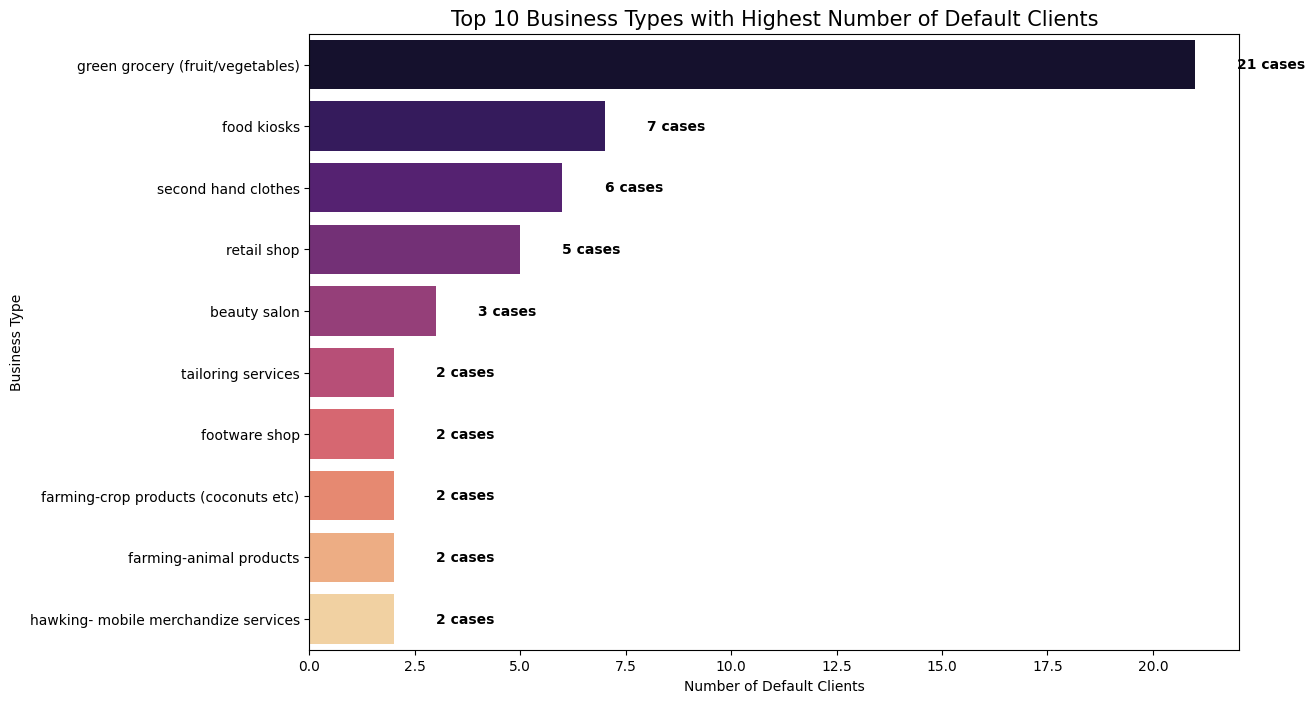

                            BusinessType  Total_Clients  Default_Clients  \
22      green grocery (fruit/vegetables)            492               21   
20                           food kiosks            212                7   
42                   second hand clothes             72                6   
40                           retail shop            139                5   
5                           beauty salon             41                3   
43                    tailoring services             33                2   
21                         footware shop             19                2   
18  farming-crop products (coconuts etc)             30                2   
17               farming-animal products             58                2   
23  hawking- mobile merchandize services             22                2   

    Default_Rate_%  
22        4.268293  
20        3.301887  
42        8.333333  
40        3.597122  
5         7.317073  
43        6.060606  
21       10.5263

In [335]:
# 1. Assuming 'Default' column is already created by your teammate
# If not, we use the logic: (df['ClearDate'] > '2025-12-15') & (df['LoanBalance'] > 0)
if 'Default' not in df.columns:
    df['Default'] = ((df['ClearDate'] > '2025-12-15') & (df['LoanBalance'] > 0)).astype(int)

# 2. Group by BusinessType to get total and default counts
business_analysis = df.groupby('BusinessType').agg(
    Total_Clients=('LoanId', 'count'),
    Default_Clients=('Default', 'sum')
).reset_index()

# 3. Calculate Default Rate (%) for better context
business_analysis['Default_Rate_%'] = (business_analysis['Default_Clients'] / business_analysis['Total_Clients']) * 100
business_analysis = business_analysis.sort_values(by='Default_Clients', ascending=False)

# 4. Visualize the top 10 Business Types with most Defaulters
plt.figure(figsize=(12, 8))
sns.barplot(data=business_analysis.head(10), x='Default_Clients', y='BusinessType', palette='magma')

# Add value labels
for i, val in enumerate(business_analysis.head(10)['Default_Clients']):
    plt.text(val + 1, i, f'{int(val)} cases', va='center', fontweight='bold')

plt.title('Top 10 Business Types with Highest Number of Default Clients', fontsize=15)
plt.xlabel('Number of Default Clients')
plt.ylabel('Business Type')
plt.show()

# Display the table
print(business_analysis[['BusinessType', 'Total_Clients', 'Default_Clients', 'Default_Rate_%']].head(10))

# FEATURE ENGINEERING

This dataset captures the full loan lifecycle of microfinance customers, combining customer demographics, business attributes, loan characteristics, and repayment behavior.

**Problem statement: How can we predict and manage default risk in microfinance by leveraging customer history, loan characteristics, and repayment behavior?**
- Which customer behaviors (missed instalments, repayment frequency, overpayments) are strongest predictors of default?
- How does loan experience (cycle count) affect repayment risk?
- Are certain loan products (5-week vs 7-week vs 10-week) inherently riskier?
- Can we optimize loan limits and approval thresholds to balance growth and risk?
- Do customers who pay late but repay in full represent higher capacity or higher risk?


### Handle categorical features 

In [376]:
df.head()

,LoanId,AmountDisbursed,Interest,LoanBalance,BorrowDate,Product,Branch,ClearDate,CustomerId,Gender,LoanLimit,CreditScore,loan_repayment_txn_count,loan_repayment_total_paid,loan_repayment_first_payment,loan_repayment_last_payment,loan_overpayment,MissedInstalments,Industry,BusinessType,YearEstablished,days_to_first,Product_Code,Branch_Code,ScoreRange,IsDefault,LoanAmountBin,LoanRepaymentTxnCountBin,Loan_Sequence,Prev_MissedInstalments,Prev_TxnCount,RepaymentDuration,Default
2576,646265,10000,2750,0.0,2024-02-13,5 weeks credit ease,molo,2024-12-02,23,male,17500.0,1800,13,12750,2025-04-30,2025-08-20,0,5.0,natural resources/environmental,firewood & charcoal vendor,2022,442,1,1,2k,0,10k-15k,10-19,2,NaN,NaN,293,0
124,720868,10000,3850,0.0,2024-05-09,7 weeks credit ease,molo,2024-05-09,23,male,10000.0,2000,1,264,2025-08-20,2025-08-20,0,7.0,food & hospitality,green grocery (fruit/vegetables),2012,468,2,1,2.5k,0,10k-15k,0-4,3,5.0,13.0,0,0
521,650669,6000,1750,0.0,2024-02-19,5 weeks credit ease,molo,2024-02-22,90,male,15000.0,2000,4,7750,2025-08-25,2025-09-09,0,5.0,food & hospitality,green grocery (fruit/vegetables),2019,553,1,1,2.5k,0,5k-10k,0-4,2,NaN,NaN,3,0
2005,705587,5000,1500,0.0,2024-07-16,5 weeks credit ease,molo,2024-07-16,90,male,7900.0,2000,9,6500,2025-09-20,2025-10-09,0,5.0,fashion & beauty products,second hand clothes,2019,431,1,1,2.5k,0,5k-10k,5-9,3,5.0,4.0,0,0
2192,720456,10000,2750,0.0,2024-08-20,5 weeks credit ease,molo,2024-08-21,90,male,11400.0,2500,10,12750,2025-10-09,2025-11-17,0,5.0,fashion & beauty products,second hand clothes,2019,415,1,1,3k,0,10k-15k,10-19,4,5.0,9.0,1,0


In [377]:
df.select_dtypes(include='category').columns


Index(['ScoreRange', 'LoanAmountBin', 'LoanRepaymentTxnCountBin'], dtype='object')

In [378]:
categorical_features = df.select_dtypes(
    include=['object', 'category']
).columns.tolist()

In [379]:
categorical_features

['Product',
 'Branch',
 'Gender',
 'Industry',
 'BusinessType',
 'ScoreRange',
 'LoanAmountBin',
 'LoanRepaymentTxnCountBin']

In [380]:
# Make a copy to do feature engineering 
data = df.copy()

In [381]:
data.head()

,LoanId,AmountDisbursed,Interest,LoanBalance,BorrowDate,Product,Branch,ClearDate,CustomerId,Gender,LoanLimit,CreditScore,loan_repayment_txn_count,loan_repayment_total_paid,loan_repayment_first_payment,loan_repayment_last_payment,loan_overpayment,MissedInstalments,Industry,BusinessType,YearEstablished,days_to_first,Product_Code,Branch_Code,ScoreRange,IsDefault,LoanAmountBin,LoanRepaymentTxnCountBin,Loan_Sequence,Prev_MissedInstalments,Prev_TxnCount,RepaymentDuration,Default
2576,646265,10000,2750,0.0,2024-02-13,5 weeks credit ease,molo,2024-12-02,23,male,17500.0,1800,13,12750,2025-04-30,2025-08-20,0,5.0,natural resources/environmental,firewood & charcoal vendor,2022,442,1,1,2k,0,10k-15k,10-19,2,NaN,NaN,293,0
124,720868,10000,3850,0.0,2024-05-09,7 weeks credit ease,molo,2024-05-09,23,male,10000.0,2000,1,264,2025-08-20,2025-08-20,0,7.0,food & hospitality,green grocery (fruit/vegetables),2012,468,2,1,2.5k,0,10k-15k,0-4,3,5.0,13.0,0,0
521,650669,6000,1750,0.0,2024-02-19,5 weeks credit ease,molo,2024-02-22,90,male,15000.0,2000,4,7750,2025-08-25,2025-09-09,0,5.0,food & hospitality,green grocery (fruit/vegetables),2019,553,1,1,2.5k,0,5k-10k,0-4,2,NaN,NaN,3,0
2005,705587,5000,1500,0.0,2024-07-16,5 weeks credit ease,molo,2024-07-16,90,male,7900.0,2000,9,6500,2025-09-20,2025-10-09,0,5.0,fashion & beauty products,second hand clothes,2019,431,1,1,2.5k,0,5k-10k,5-9,3,5.0,4.0,0,0
2192,720456,10000,2750,0.0,2024-08-20,5 weeks credit ease,molo,2024-08-21,90,male,11400.0,2500,10,12750,2025-10-09,2025-11-17,0,5.0,fashion & beauty products,second hand clothes,2019,415,1,1,3k,0,10k-15k,10-19,4,5.0,9.0,1,0


In [382]:
print("Branch:", data["Branch"].unique())


Branch: ['molo' 'engineer']


In [383]:
print("Product:", data["Product"].unique())

Product: ['5 weeks credit ease' '7 weeks credit ease' '10 weeks credit ease']


In [384]:
print("Industry:", data["Industry"].unique())
print(data["Industry"].value_counts())

Industry: ['natural resources/environmental' 'food & hospitality'
 'fashion & beauty products' 'hospitality & tourism' 'agriculture'
 'manufacturing' 'wholesale & retail trade' 'personal services'
 'transportation' 'automobile services' 'real estate & housing'
 'not defined' 'personal & professional services'
 'human health & animal services' 'general hardware & electronics'
 'agriculture, forestry & fishing' 'education' 'finance & insurance'
 'business & information' 'construction & real estate']
Industry
food & hospitality                  923
fashion & beauty products           157
personal services                   128
agriculture                          65
transportation                       42
wholesale & retail trade             37
natural resources/environmental      37
general hardware & electronics       34
agriculture, forestry & fishing      27
personal & professional services     22
manufacturing                        21
human health & animal services       19
not defi

In [385]:
print("BusinessType:", data["BusinessType"].unique())

print(data["BusinessType"].value_counts())

BusinessType: ['firewood & charcoal vendor' 'green grocery (fruit/vegetables)'
 'second hand clothes' 'entertainment/party & events planning'
 'farming-animal products' 'food kiosks' 'tailoring services'
 'retail shop' 'cosmetic shop' 'bar/ restaurant' 'seafood- fish vendor'
 'farming-crop products (coconuts etc)' 'cereals' 'ice cream'
 'beauty salon' 'beverage manufacturing- juice etc' 'meat vendor-butchery'
 'taxi & rental services' 'hawking- mobile merchandize services'
 'warehouse & equipment rental' 'motor bike transportation'
 'footware shop' 'barber shop' 'pharmacy/dispensing chemist'
 'water vending' 'new clothes' 'building & construction materials'
 'caterer' 'workshop (wood & metal)' 'electronic accessory shops/repairs'
 'mobile money services-mpesa' 'private school' 'other'
 'bureau & publishing services' 'household utensils' 'agro-vet'
 'oil & gas distribution' 'motor vehicle/bike repair'
 'bakery (bread & confectionaries)' 'private health services'
 'contractor/plumbing & 

In [386]:
print("ScoreRange:", data["ScoreRange"].unique())

print(data["ScoreRange"].value_counts())


ScoreRange: ['2k', '2.5k', '3k', '7.5k', '20.5k', '4k', '3.5k', '15.5k', '0.5k', '1.5k']
Categories (41, object): ['0.5k' < '1k' < '1.5k' < '2k' ... '19k' < '19.5k' < '20k' < '20.5k']
ScoreRange
3k       575
2.5k     518
2k       272
3.5k      93
7.5k      48
20.5k     22
4k        19
15.5k      9
0.5k       5
1.5k       4
5k         0
5.5k       0
20k        0
19.5k      0
19k        0
18.5k      0
18k        0
17.5k      0
17k        0
16.5k      0
16k        0
15k        0
14.5k      0
14k        0
13.5k      0
13k        0
12.5k      0
12k        0
11.5k      0
11k        0
1k         0
10k        0
9.5k       0
9k         0
8.5k       0
8k         0
4.5k       0
7k         0
6.5k       0
6k         0
10.5k      0
Name: count, dtype: int64


In [387]:
print("LoanAmountBin:", data["LoanAmountBin"].unique())

print(data["LoanAmountBin"].value_counts())

LoanAmountBin: ['10k-15k', '5k-10k', '0-5k', '15k-20k', '20k-30k', '30k-60k']
Categories (7, object): ['0-5k' < '5k-10k' < '10k-15k' < '15k-20k' < '20k-30k' < '30k-60k' < '60k-100k']
LoanAmountBin
5k-10k      1025
10k-15k      308
0-5k          82
15k-20k       72
20k-30k       58
30k-60k       20
60k-100k       0
Name: count, dtype: int64


In [388]:
# Check number of categories before doing encoding 

for col in ["Industry", "BusinessType", "Product", "Branch"]:
    print(col, "→", data[col].nunique())

# Industry → group rare categories into others (make it less than 10) 
# BusinessType → group rare categories into others (make it less than 20) 
# Product & Branch → one-hot encoding 


Industry → 20
BusinessType → 48
Product → 3
Branch → 2


In [389]:
# Group rare categories into "Other"

# BusinessType 
business_type = data['BusinessType'].value_counts()
rare = business_type[business_type < 20].index #keep the categories that have the values > 20 

data['BusinessType_clean'] = data['BusinessType'].replace(rare, 'Other')


In [390]:
# Industry
industry_count = df['Industry'].value_counts()
rare = industry_count[industry_count < 20].index #keep the categories that have the values > 20 

data['Industry_clean'] = data['Industry'].replace(rare, 'Other')

In [391]:
data = pd.get_dummies(
    data,
    columns=['BusinessType_clean', 'Industry_clean', 'Product', 'Branch', 'Gender'],
    drop_first=True
)

data = data.drop(columns=['Industry', 'BusinessType'])

In [392]:
data.head()

,LoanId,AmountDisbursed,Interest,LoanBalance,BorrowDate,ClearDate,CustomerId,LoanLimit,CreditScore,loan_repayment_txn_count,loan_repayment_total_paid,loan_repayment_first_payment,loan_repayment_last_payment,loan_overpayment,MissedInstalments,YearEstablished,days_to_first,Product_Code,Branch_Code,ScoreRange,IsDefault,LoanAmountBin,LoanRepaymentTxnCountBin,Loan_Sequence,Prev_MissedInstalments,Prev_TxnCount,RepaymentDuration,Default,BusinessType_clean_bar/ restaurant,BusinessType_clean_barber shop,BusinessType_clean_beauty salon,BusinessType_clean_building & construction materials,BusinessType_clean_cereals,BusinessType_clean_farming-animal products,BusinessType_clean_farming-crop products (coconuts etc),BusinessType_clean_firewood & charcoal vendor,BusinessType_clean_food kiosks,BusinessType_clean_green grocery (fruit/vegetables),BusinessType_clean_hawking- mobile merchandize services,BusinessType_clean_meat vendor-butchery,BusinessType_clean_motor bike transportation,BusinessType_clean_new clothes,BusinessType_clean_retail shop,BusinessType_clean_second hand clothes,BusinessType_clean_tailoring services,Industry_clean_agriculture,"Industry_clean_agriculture, forestry & fishing",Industry_clean_fashion & beauty products,Industry_clean_food & hospitality,Industry_clean_general hardware & electronics,Industry_clean_manufacturing,Industry_clean_natural resources/environmental,Industry_clean_personal & professional services,Industry_clean_personal services,Industry_clean_transportation,Industry_clean_wholesale & retail trade,Product_5 weeks credit ease,Product_7 weeks credit ease,Branch_molo,Gender_male
2576,646265,10000,2750,0.0,2024-02-13,2024-12-02,23,17500.0,1800,13,12750,2025-04-30,2025-08-20,0,5.0,2022,442,1,1,2k,0,10k-15k,10-19,2,NaN,NaN,293,0,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,True,False,True,True
124,720868,10000,3850,0.0,2024-05-09,2024-05-09,23,10000.0,2000,1,264,2025-08-20,2025-08-20,0,7.0,2012,468,2,1,2.5k,0,10k-15k,0-4,3,5.0,13.0,0,0,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True,True,True
521,650669,6000,1750,0.0,2024-02-19,2024-02-22,90,15000.0,2000,4,7750,2025-08-25,2025-09-09,0,5.0,2019,553,1,1,2.5k,0,5k-10k,0-4,2,NaN,NaN,3,0,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,True,False,True,True
2005,705587,5000,1500,0.0,2024-07-16,2024-07-16,90,7900.0,2000,9,6500,2025-09-20,2025-10-09,0,5.0,2019,431,1,1,2.5k,0,5k-10k,5-9,3,5.0,4.0,0,0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,True,False,False,False,False,False,False,False,False,True,False,True,True
2192,720456,10000,2750,0.0,2024-08-20,2024-08-21,90,11400.0,2500,10,12750,2025-10-09,2025-11-17,0,5.0,2019,415,1,1,3k,0,10k-15k,10-19,4,5.0,9.0,1,0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,True,False,False,False,False,False,False,False,False,True,False,True,True


In [393]:
data.shape

#62 columns

(1565, 60)

In [394]:
data.isnull().sum()

#Prev_MissedInstalments                                     629
#Prev_TxnCount                                              629

LoanId                                                       0
AmountDisbursed                                              0
Interest                                                     0
LoanBalance                                                  0
BorrowDate                                                   0
ClearDate                                                    0
CustomerId                                                   0
LoanLimit                                                    0
CreditScore                                                  0
loan_repayment_txn_count                                     0
loan_repayment_total_paid                                    0
loan_repayment_first_payment                                 0
loan_repayment_last_payment                                  0
loan_overpayment                                             0
MissedInstalments                                            0
YearEstablished                                        

In [395]:
# Replace missing values with mode
data["Prev_MissedInstalments"] = data["Prev_MissedInstalments"].fillna(data["Prev_MissedInstalments"].mode(dropna=True)[0])
data["Prev_TxnCount"] = data["Prev_TxnCount"].fillna(data["Prev_TxnCount"].mode(dropna=True)[0])


In [396]:
# Check NaN value
data["Prev_MissedInstalments"].isnull().sum()
data["Prev_TxnCount"].isnull().sum()

np.int64(0)

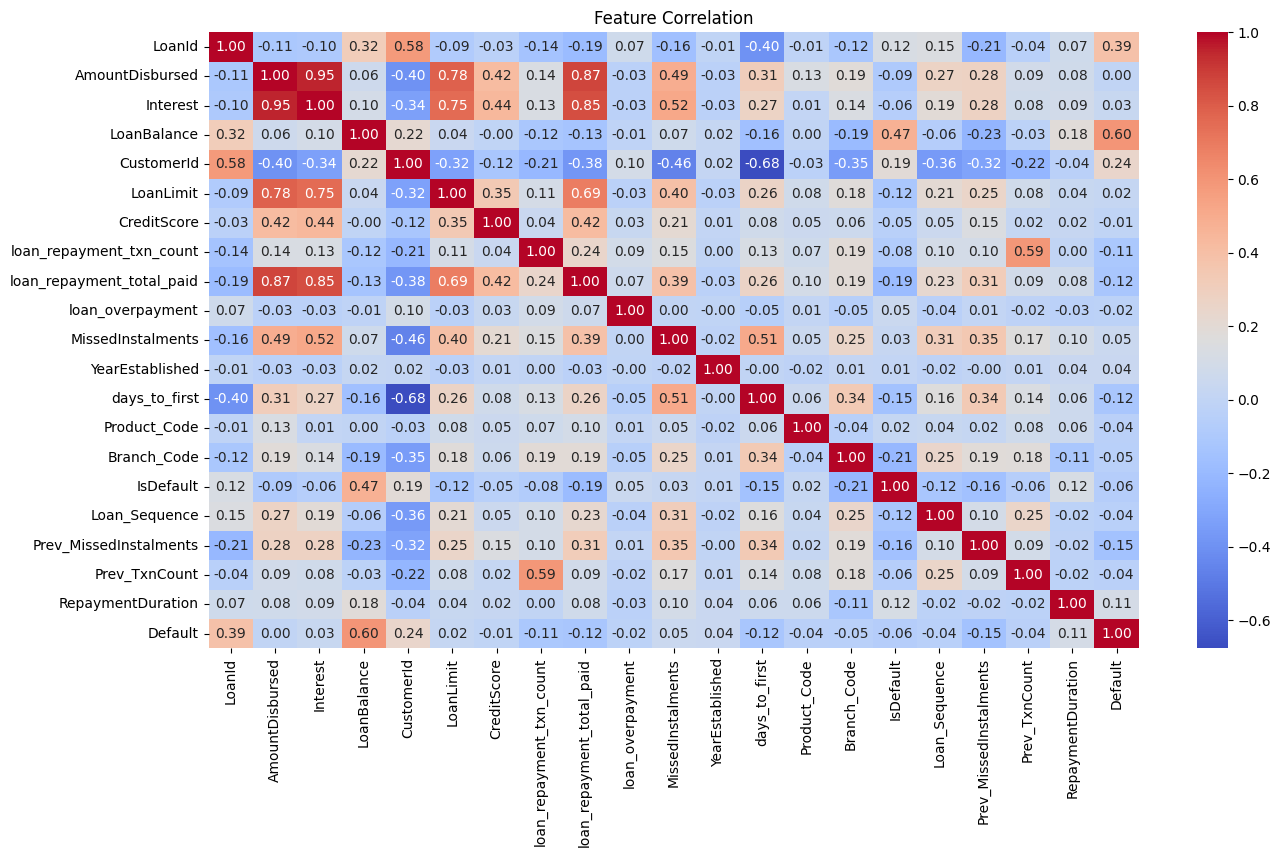

In [397]:
# Correlation (numerical & categorical values)

plt.figure(figsize=(15, 8))

numeric_data = data.select_dtypes(include='number')

correlations = numeric_data.corr()

sns.heatmap(
    correlations,
    annot=True,
    cmap='coolwarm',
    fmt=".2f"
)
plt.title('Feature Correlation')
plt.show()


**New features:**
- LoanAmountBin: groups loan amounts into meaningful ranges
- RepaymentDuration: repayment duration in days 
- Loan_Sequence: indicates how many times a customer has borrowed
- Prev_MissedInstalments: the number of missed repayments in the customer’s immediately previous loan
- Prev_TxnCount: how many repayment transactions the customer made in their previous loan

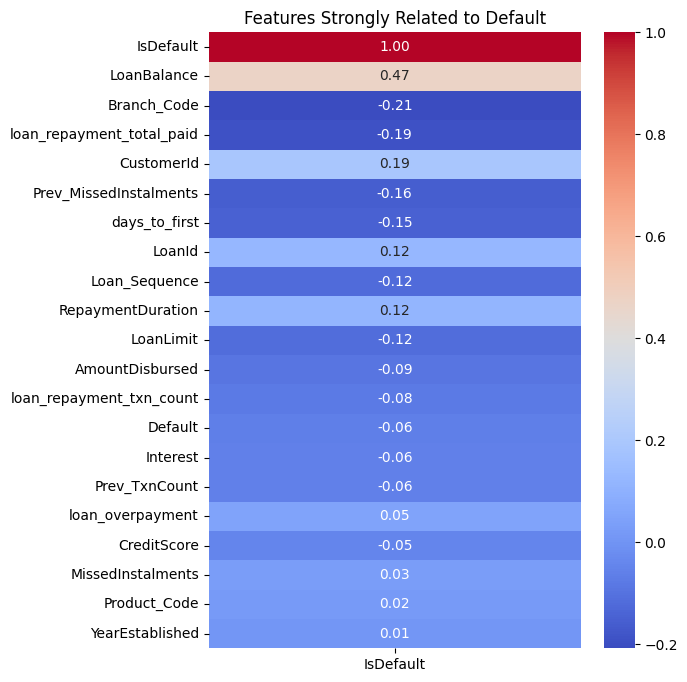

In [398]:
corr = data.select_dtypes(include='number').corr()

target_corr = corr['IsDefault'].sort_values(key=abs, ascending=False)

plt.figure(figsize=(6, 8))
sns.heatmap(
    target_corr.to_frame(),
    annot=True,
    cmap='coolwarm',
    fmt=".2f"
)
plt.title('Features Strongly Related to Default')
plt.show()


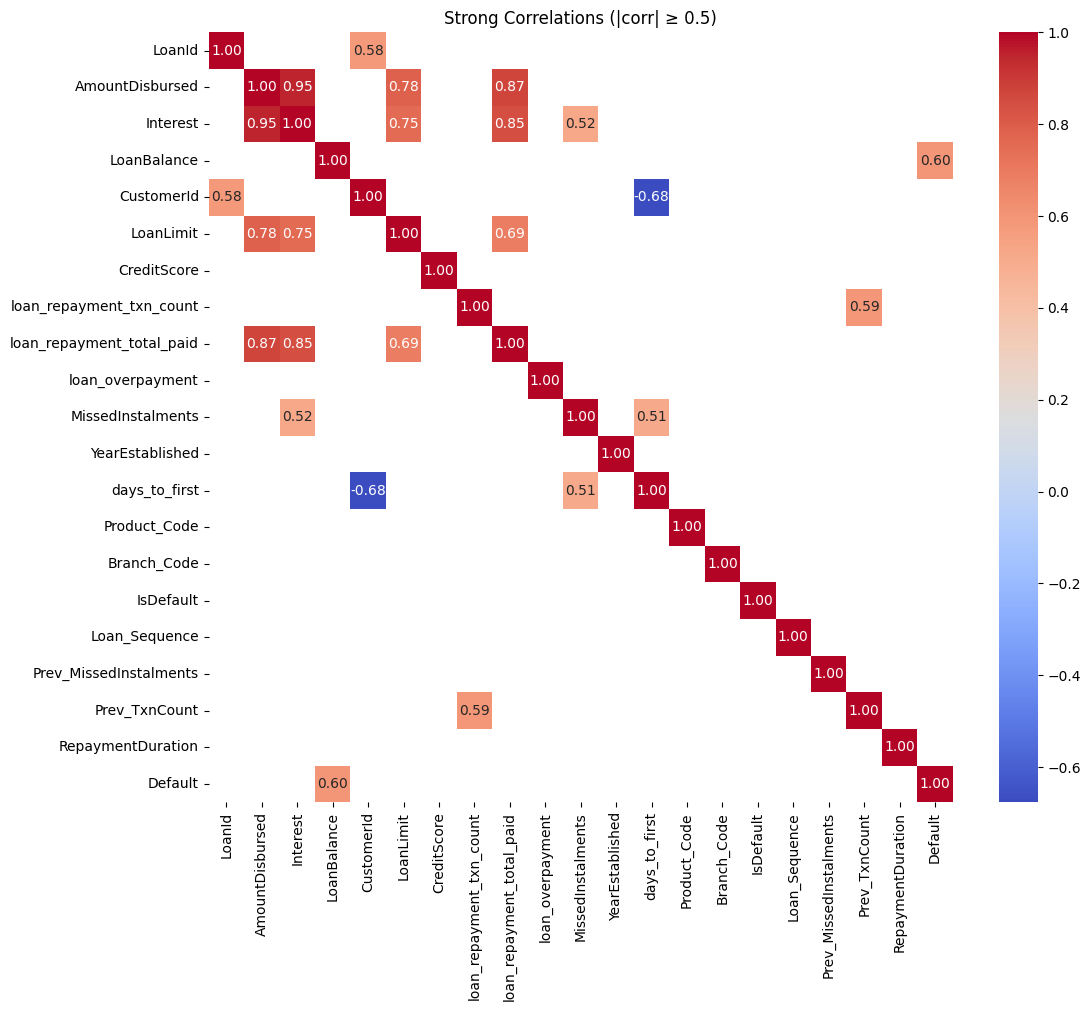

In [399]:
corr = data.select_dtypes(include='number').corr()
threshold = 0.5

strong_corr = corr.where(abs(corr) >= threshold)

plt.figure(figsize=(12, 10))
sns.heatmap(
    strong_corr,
    cmap='coolwarm',
    annot=True,
    fmt=".2f",
    mask=strong_corr.isna()
)
plt.title(f'Strong Correlations (|corr| ≥ {threshold})')
plt.show()

**New relationships to look into:**

- Loan Utilization: df['AmountDisbursed'] & df['LoanLimit'] - Customers borrowing close to their limit → higher stress
- Repayment intensity: df['loan_repayment_txn_count'] & df['RepaymentDuration'] - frequent small repayments (good discipline)

#### **USE ML to select which features to engineer/keep/drop**


In [ ]:
# import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer

In [ ]:
from sklearn.decomposition import PCA

# Select highly correlated money-related features to reduce redundancy
pca_features = ["AmountDisbursed", "Interest", "LoanBalance", "LoanLimit", "loan_repayment_total_paid"]
pca_features = [c for c in pca_features if c in data.columns]

# Build a PCA pipeline: handle missing values, standardize scales, and extract principal components
pca_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("pca", PCA(n_components=2, random_state=42))
])

pc = pca_pipe.fit_transform(data[pca_features])
data["PC1_money"] = pc[:, 0]
data["PC2_money"] = pc[:, 1]


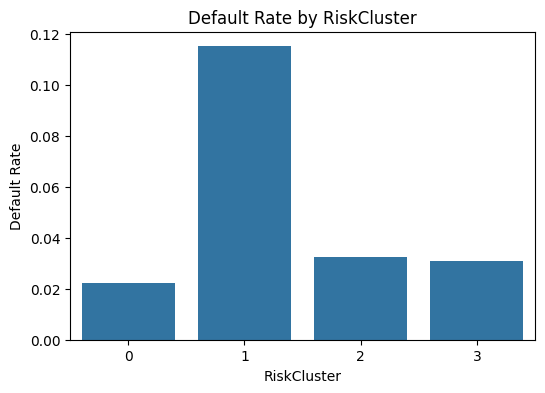

In [ ]:
# Compute the average default rate for each risk cluster
cluster_summary = data.groupby("RiskCluster")["IsDefault"].mean().reset_index()

# Visualize default rates across clusters
plt.figure(figsize=(6,4))
sns.barplot(
    data=cluster_summary,
    x="RiskCluster",
    y="IsDefault"
)
plt.title("Default Rate by RiskCluster")
plt.ylabel("Default Rate")
plt.show()


Cluster 1 (highest default)

In [419]:
seg_features = [
    "AmountDisbursed", "LoanLimit", "CreditScore",
    "MissedInstalments", "loan_repayment_txn_count",
    "loan_repayment_total_paid", "RepaymentDuration",
    "Prev_MissedInstalments", "Prev_TxnCount", "Loan_Sequence"
]
cluster_profile = (
    df.groupby("RiskCluster")[seg_features + ["IsDefault"]]
      .median()
      .sort_values("IsDefault", ascending=False)
)

cluster_profile


,AmountDisbursed,LoanLimit,CreditScore,MissedInstalments,loan_repayment_txn_count,loan_repayment_total_paid,RepaymentDuration,Prev_MissedInstalments,Prev_TxnCount,Loan_Sequence,IsDefault
RiskCluster,,,,,,,,,,,
0,9000.0,14000.0,2000.0,5.0,12.0,10575.0,6.0,5.0,13.0,7.0,0.0
1,5000.0,10000.0,2000.0,3.0,6.0,6500.0,13.0,1.0,7.0,2.0,0.0
2,18000.0,30700.0,20000.0,7.0,14.0,24650.0,30.0,7.0,12.0,4.0,0.0
3,18000.0,32450.0,2500.0,7.0,12.0,23000.0,27.0,7.0,10.0,4.0,0.0


**Cluster 1: Smaller loans, low repayment activity, short repayment duration → fragile borrowers**

AmountDisbursed ↓ loan_repayment_txn_count ↓ RepaymentDuration ↓ MissedInstalments

--> Smaller loans, low repayment activity, short repayment duration → fragile borrowers
--> Defaults concentrate among customers with low repayment engagement and short repayment histories, rather than purely high loan amounts.

**Features to be engineered to reflect above relationships:**
- repayment engagement: df["Txn_Intensity"] = df["loan_repayment_txn_count"] / (df["RepaymentDuration"] + 1) - captures low repayment activity normalized by time (3 payments in 10 days ≠ 3 payments in 60 days)
- missed_rate: df["Missed_Rate"] = df["MissedInstalments"] / (df["loan_repayment_txn_count"] + 1)
- late first payment (for early warning): df["Late_First_Payment"] = (df["days_to_first"] > 7).astype(int)
- Loan Utilization: df['AmountDisbursed'] & df['LoanLimit'] - Customers borrowing close to their limit → higher stress


In [421]:
# Repayment engagement (normalized by time)
data["Txn_Intensity"] = (
    data["loan_repayment_txn_count"] / (data["RepaymentDuration"] + 1)
)

# Missed installments relative to repayment activity
data["Missed_Rate"] = (
    data["MissedInstalments"] / (data["loan_repayment_txn_count"] + 1)
)

# Early warning: late first repayment
data["Late_First_Payment"] = (data["days_to_first"] > 7).astype(int)

# Loan utilization (capacity stress)
data["Loan_Utilization"] = (
    data["AmountDisbursed"] / (data["LoanLimit"] + 1)
)


In [422]:
feature_cols = [
    "Txn_Intensity",
    "Missed_Rate",
    "Late_First_Payment",
    "Loan_Utilization",
    "IsDefault"
]

corr_data = data[feature_cols].corr()


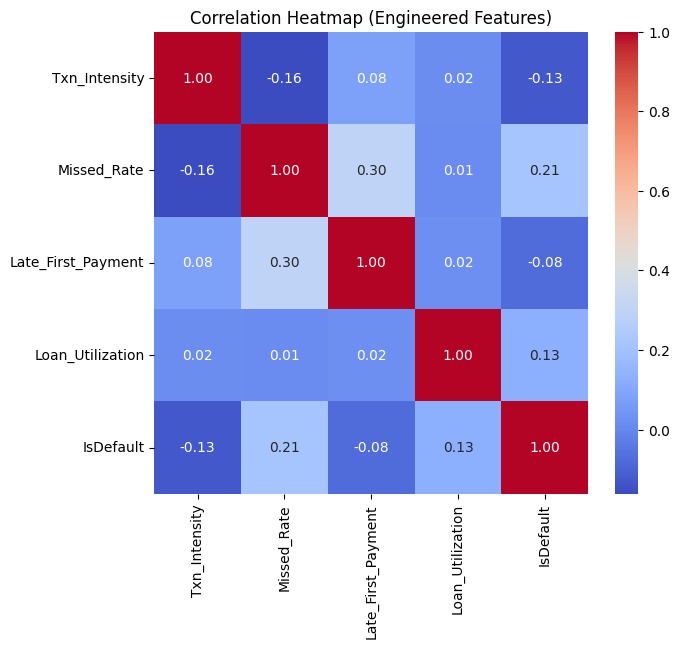

In [423]:
plt.figure(figsize=(7,6))
sns.heatmap(
    corr_data,
    annot=True,
    cmap="coolwarm",
    fmt=".2f"
)
plt.title("Correlation Heatmap (Engineered Features)")
plt.show()

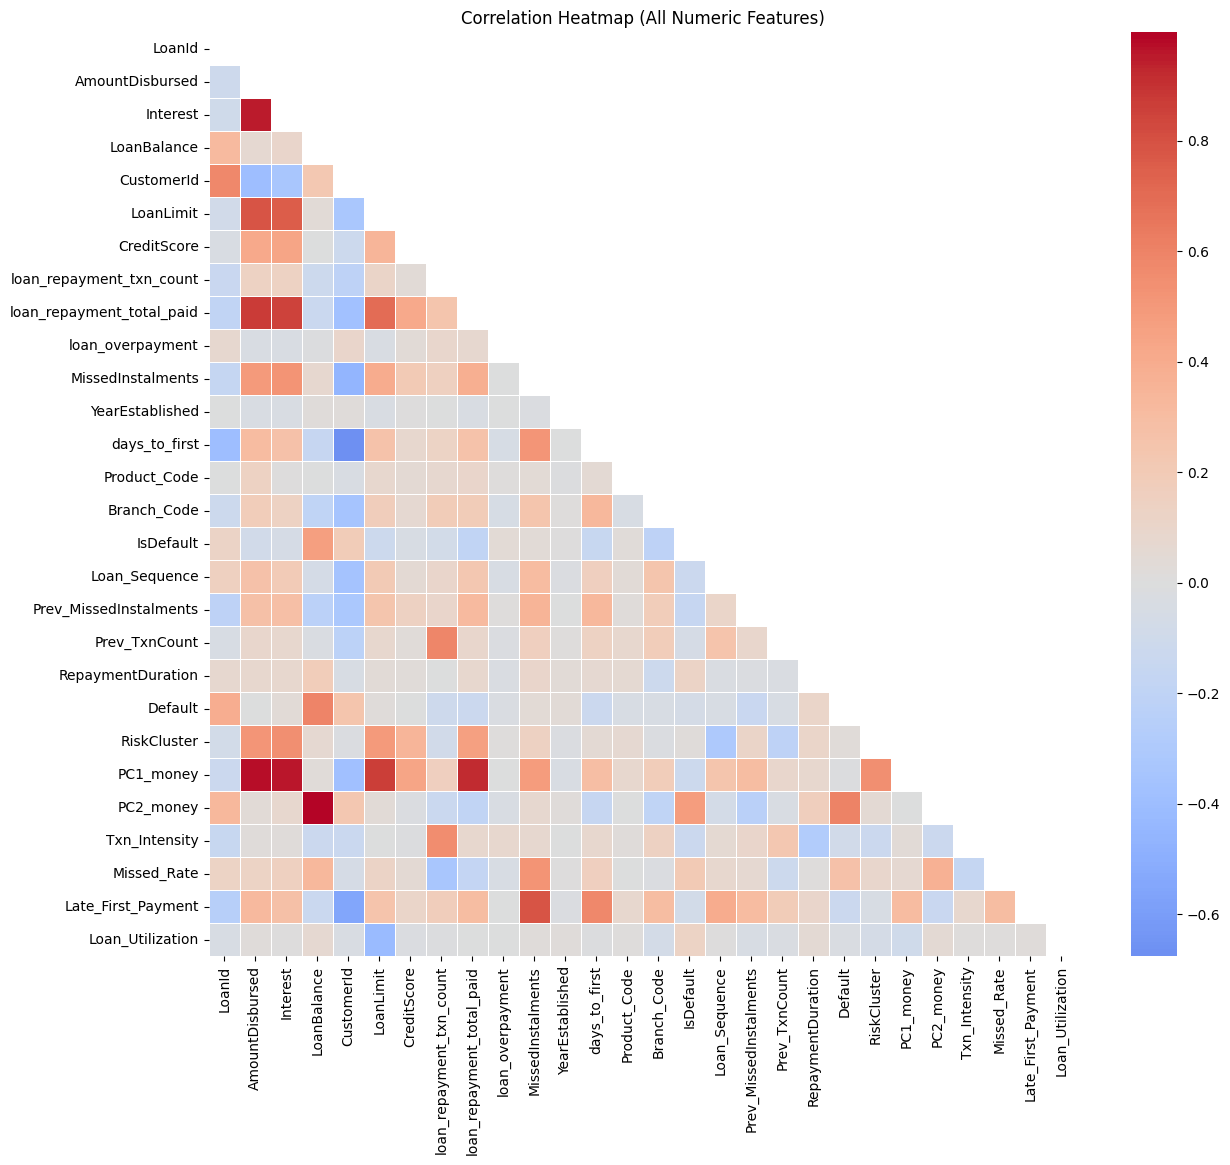

In [424]:
# Select only numeric columns
num_df = data.select_dtypes(include=["number"])

# Compute correlation matrix
corr = num_df.corr()

mask = np.triu(np.ones_like(corr, dtype=bool))

plt.figure(figsize=(14, 12))
sns.heatmap(
    corr,
    mask=mask,
    cmap="coolwarm",
    center=0,
    fmt=".2f",
    linewidths=0.5
)
plt.title("Correlation Heatmap (All Numeric Features)")
plt.show()


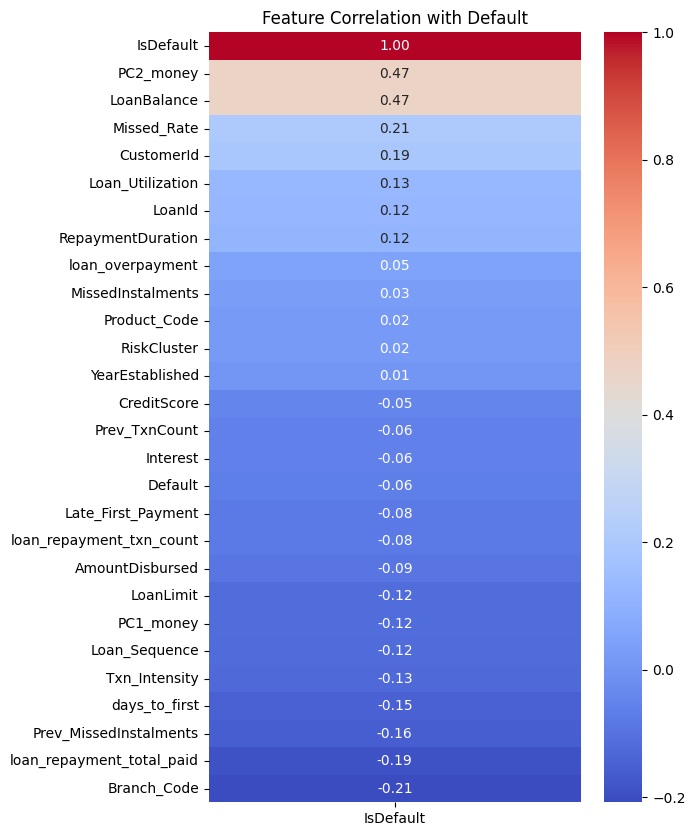

In [425]:
target_corr = corr[["IsDefault"]].sort_values("IsDefault", ascending=False)

plt.figure(figsize=(6, 10))
sns.heatmap(
    target_corr,
    annot=True,
    cmap="coolwarm",
    fmt=".2f"
)
plt.title("Feature Correlation with Default")
plt.show()


Risk is driven more by repayment stress than loan size
- PC2_money - “repayment pressure / outstanding burden”: principal component created by PCA from these original features

["AmountDisbursed", "Interest", "LoanBalance", "LoanLimit", "loan_repayment_total_paid"]

- Missed behavior matters more than raw missed counts

Missed_Rate (0.21) correlates more with default than MissedInstalments (0.03)

- negative correlations ("Txn_Intensity", "Loan_Sequence", "days_to_first", Prev_MissedInstalments) mean Experienced borrowers who repay actively and early are less likely to default.

- CreditScore (-0.05) shows only a mild relationship.

- CustomerId (0.19), LoanId (0.12), Branch_Code (-0.21) not causal and should not be used directly for modeling.


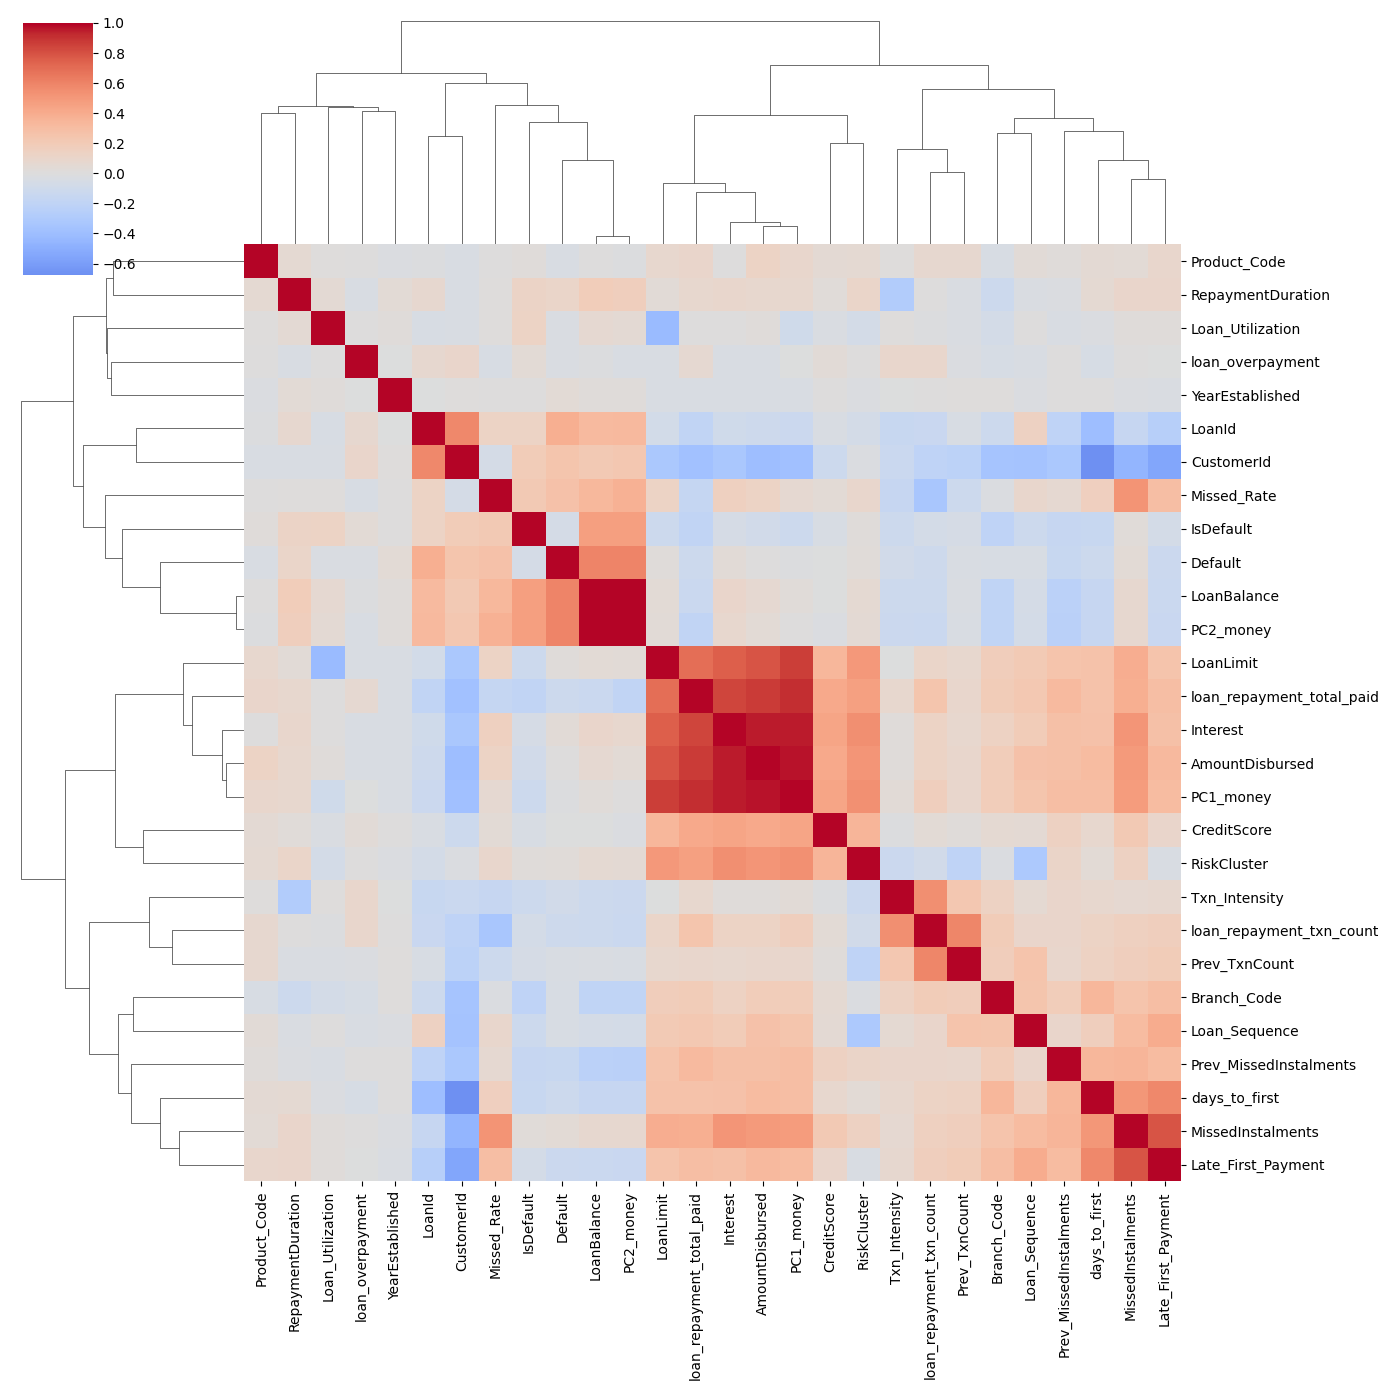

In [426]:
sns.clustermap(
    corr,
    cmap="coolwarm",
    center=0,
    figsize=(14, 14)
)
plt.show()

**KEEP (high value)**
- PC2_money or LoanBalance (not both)

PC2_money = ["AmountDisbursed", "Interest", "LoanBalance", "LoanLimit", "loan_repayment_total_paid"]

- Missed_Rate
- Loan_Utilization
- Txn_Intensity
- days_to_first
- Loan_Sequence
- Prev_MissedInstalments

**DROP / DE-PRIORITIZE**
- LoanId, CustomerId
- Raw MissedInstalments
- Raw AmountDisbursed
- Interest
- Branch_Code